In [10]:
# Data preparation for Ph.D thesis
# @author: Andres L. Suarez-Cetrulo
%config IPCompleter.greedy=True
%load_ext jupyternotify
%matplotlib inline

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [11]:
import subprocess
# Define this to parse the CSVs to ARFF later automatically
def create_arff_file(filename, output=None):
    java_mem = '-Xmx3074m'
    filename = filename.replace('.csv', '')
    if output is None:
        output=filename
    else:
        output = output.replace('.csv', '')
    wekadev_libpath = 'C:\\Users\\suare\\Workspace\\phd_cetrulin\\moa-2017.06-sources\\lib\\weka-dev-3.7.12.jar'
    command = ['java', java_mem, '-classpath', wekadev_libpath,
               'weka.core.converters.CSVLoader', filename + '.csv', '>', output + '.arff']
    f = open(filename + '.arff', "w")
    subprocess.call(command, stdout=f)
    print('If the arff is not generated, run the next in the terminal.')
    print(str(' '.join(command)))

In [12]:
# Imports
import pandas as pd
import numpy as np
import datetime
from pathlib import Path
import os
from matplotlib import pyplot as plt

# Using TALib abstract API to create a dictionary of technical indicators to iterate later.
from talib import abstract

In [13]:
# Creating a dictionary of technical indicators using TALib abstract API
indicators = ['sma','ema','wma','mom','stoch','macd' ,'rsi' ,'willr',
              'adosc' ,'cci','adx','aroon' ,'bbands','obv' ,'trima',
              'roc' ,'rocr','stochf','medprice','typprice','wclprice',
              'atr','macdfix','mfi' ,'sar' ,'ppo']

def get_indicator(ind: str):
    return abstract.Function(ind)

# Add as many indicators as necessary: see all indicators in https://mrjbq7.github.io/ta-lib/

# Created a wrapper/loop to process a batch of many synthetic sets

In [20]:
path_synthetic_seeds = os.sep.join(['C:', 'Users', 'suare', 'Workspace', 'phd_cetrulin', 'moa-2017.06-sources', 'data', 'synthetic', 'synthetic3'])
files = list()
for file in os.listdir(path_synthetic_seeds):
    if '.' not in file:
        seed_folder = os.sep.join([path_synthetic_seeds, file])
        seed_files = os.listdir(seed_folder)
    #     print(seed_files)
        if not any('.arff' in x for x in seed_files): 
            assert '.csv' in seed_files[0], f'Does the seed folder: {seed_folder} contain a csv? Check maybe another pos: {seed_files}'
    #         print('file: ' + file)
    #         print(seed_folder)
    #         print(os.listdir(seed_folder))
    #         print(seed_files)
    #         print(os.sep.join([seed_folder, seed_files[0]]))
            filename = seed_files[0].replace('.csv', '')
            files.append({'DATA_PATH': seed_folder, 'filename': seed_files[0].replace('.csv', '')})
    #         print(filename)
    #         print('=========')
        else:
            print('Folder ' + file + ' has an Arff already')

pd.DataFrame(files).tail()

Folder 1 has an Arff already


,DATA_PATH,filename
25,C:\Users\suare\Workspace\phd_cetrulin\moa-2017...,timeseries_created_1607434427
26,C:\Users\suare\Workspace\phd_cetrulin\moa-2017...,timeseries_created_1607435719
27,C:\Users\suare\Workspace\phd_cetrulin\moa-2017...,timeseries_created_1607435916
28,C:\Users\suare\Workspace\phd_cetrulin\moa-2017...,timeseries_created_1607438218
29,C:\Users\suare\Workspace\phd_cetrulin\moa-2017...,timeseries_created_1607438240


10 - timeseries_created_1607444006


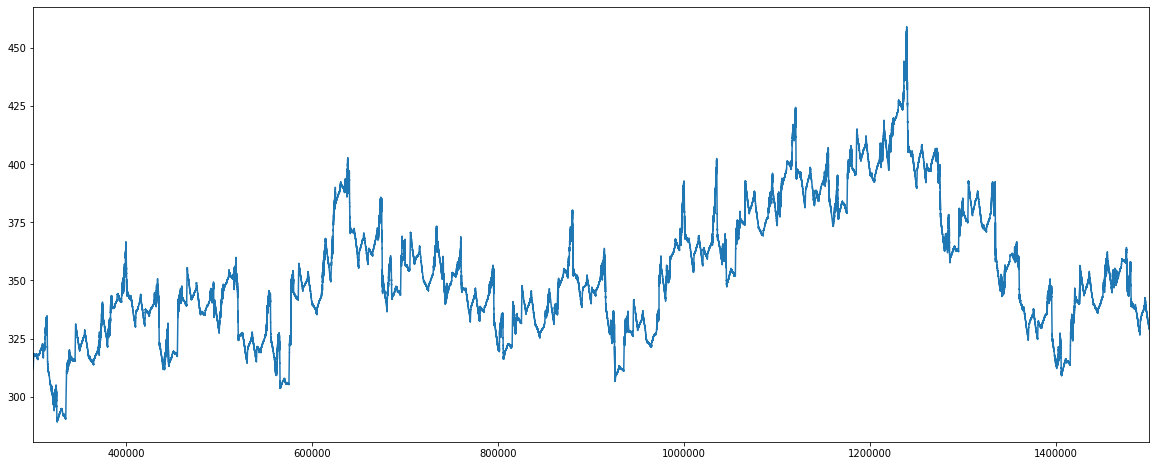

bef. devset len: 249965
devset len: 250000
trainset len: 1000000
full len: 1499965
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\10\synthetic3_train.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\10synthetic3_train.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\10\synthetic3_devset.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\10synthetic3_devset.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -class

C:\Users\suare\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\10\synthetic3_mahalanobis_state_1.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\10\synthetic3_mahalanobis_state_1.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\10\synthetic3_mahalanobis_state_2.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\10\synthetic3_mahalanobis_state_2.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspa

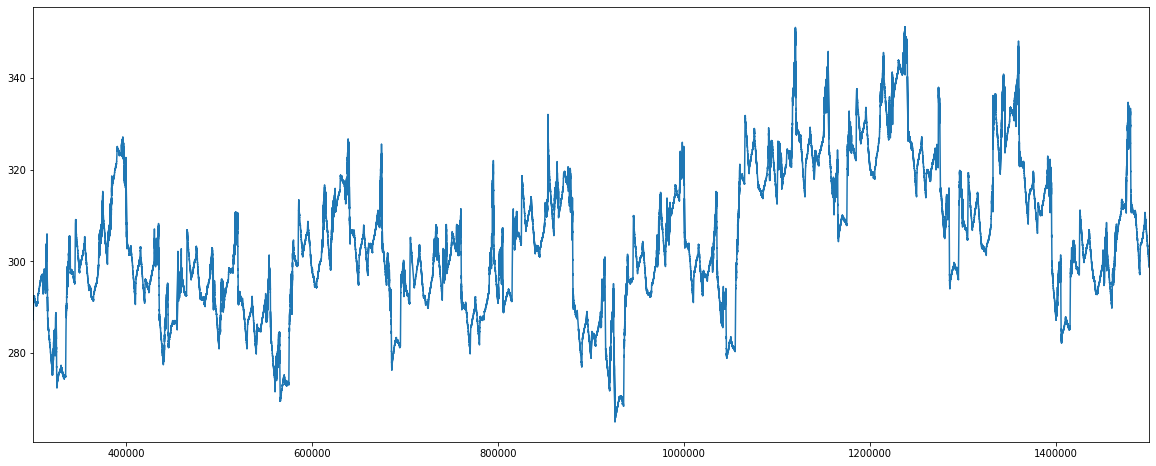

bef. devset len: 249965
devset len: 250000
trainset len: 1000000
full len: 1499965
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\11\synthetic3_train.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\11synthetic3_train.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\11\synthetic3_devset.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\11synthetic3_devset.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -class

C:\Users\suare\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\11\synthetic3_mahalanobis_state_1.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\11\synthetic3_mahalanobis_state_1.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\11\synthetic3_mahalanobis_state_2.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\11\synthetic3_mahalanobis_state_2.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspa

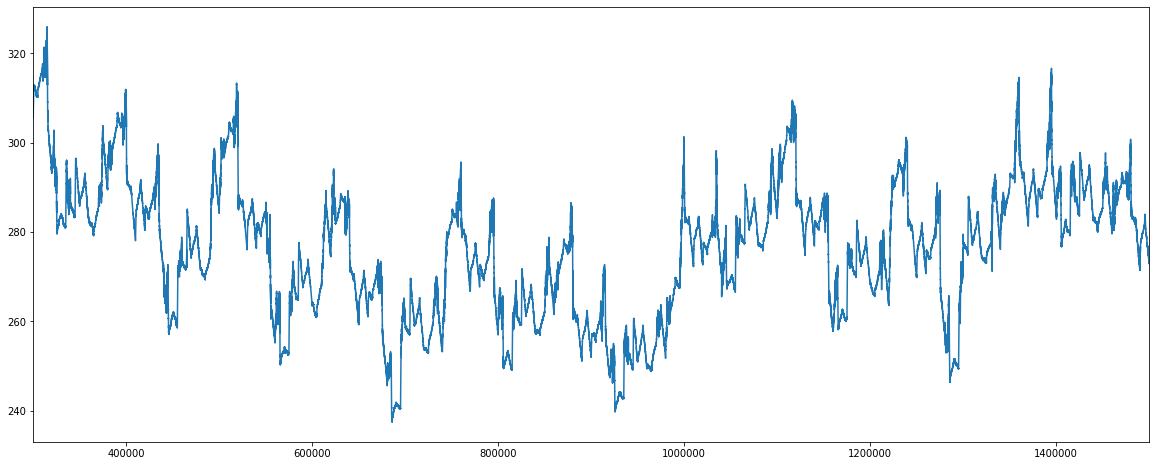

bef. devset len: 249965
devset len: 250000
trainset len: 1000000
full len: 1499965
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\12\synthetic3_train.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\12synthetic3_train.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\12\synthetic3_devset.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\12synthetic3_devset.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -class

C:\Users\suare\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\12\synthetic3_mahalanobis_state_1.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\12\synthetic3_mahalanobis_state_1.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\12\synthetic3_mahalanobis_state_2.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\12\synthetic3_mahalanobis_state_2.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspa

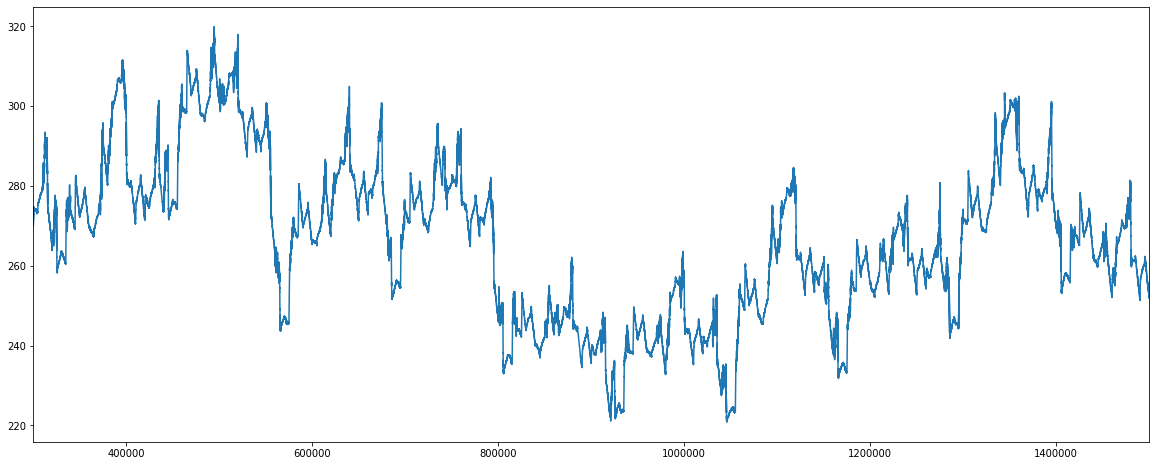

bef. devset len: 249965
devset len: 250000
trainset len: 1000000
full len: 1499965
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\13\synthetic3_train.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\13synthetic3_train.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\13\synthetic3_devset.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\13synthetic3_devset.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -class

C:\Users\suare\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\13\synthetic3_mahalanobis_state_1.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\13\synthetic3_mahalanobis_state_1.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\13\synthetic3_mahalanobis_state_2.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\13\synthetic3_mahalanobis_state_2.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspa

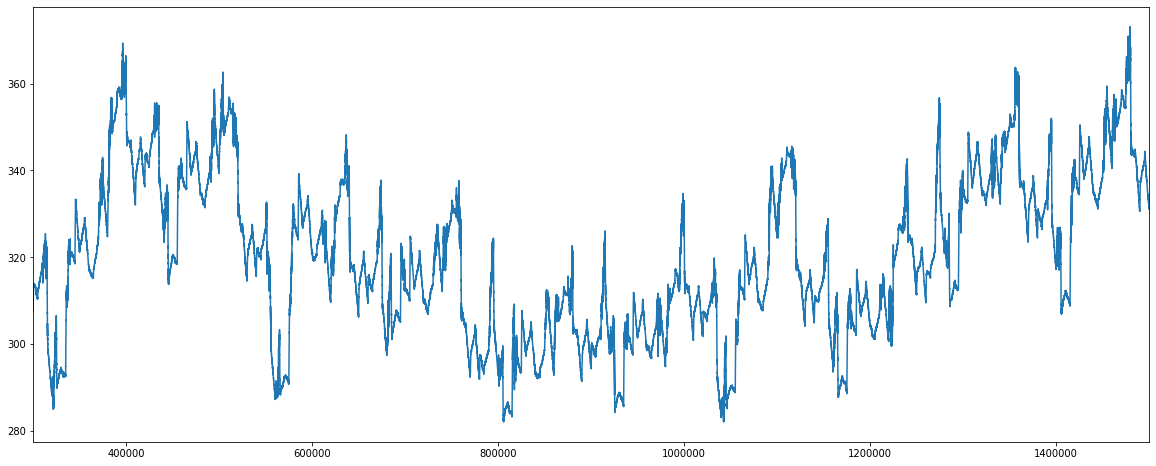

bef. devset len: 249965
devset len: 250000
trainset len: 1000000
full len: 1499965
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\14\synthetic3_train.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\14synthetic3_train.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\14\synthetic3_devset.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\14synthetic3_devset.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -class

C:\Users\suare\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\14\synthetic3_mahalanobis_state_1.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\14\synthetic3_mahalanobis_state_1.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\14\synthetic3_mahalanobis_state_2.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\14\synthetic3_mahalanobis_state_2.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspa

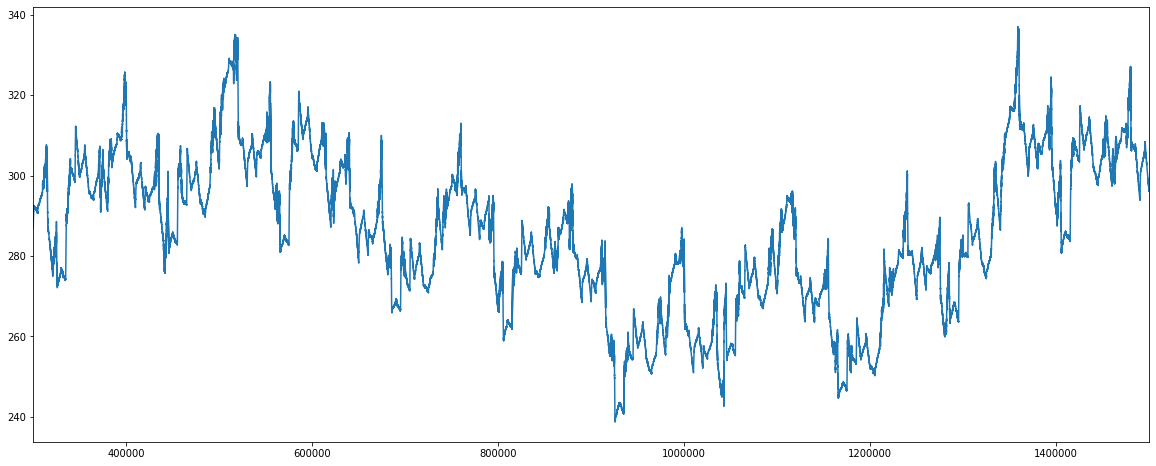

bef. devset len: 249965
devset len: 250000
trainset len: 1000000
full len: 1499965
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\15\synthetic3_train.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\15synthetic3_train.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\15\synthetic3_devset.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\15synthetic3_devset.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -class

C:\Users\suare\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\15\synthetic3_mahalanobis_state_1.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\15\synthetic3_mahalanobis_state_1.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\15\synthetic3_mahalanobis_state_2.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\15\synthetic3_mahalanobis_state_2.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspa

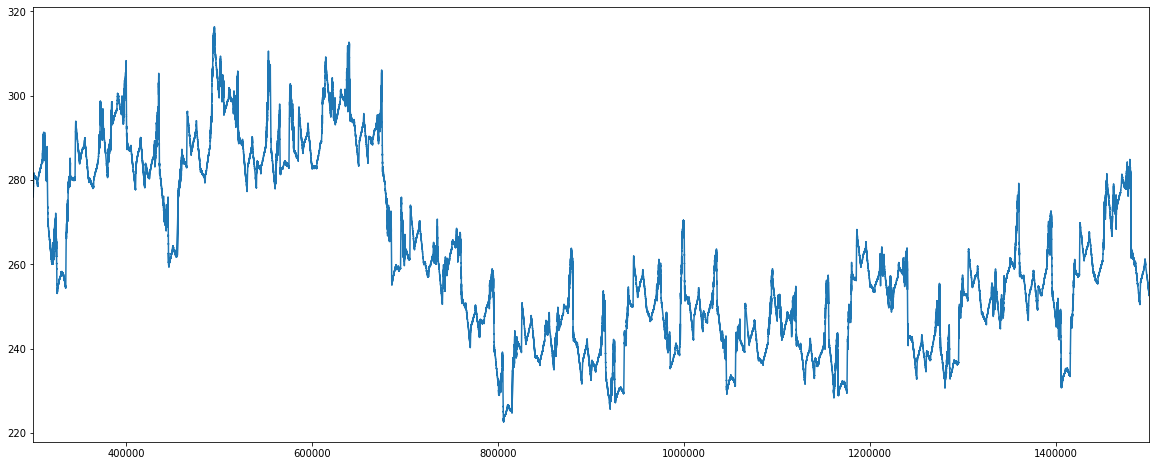

bef. devset len: 249965
devset len: 250000
trainset len: 1000000
full len: 1499965
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\16\synthetic3_train.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\16synthetic3_train.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\16\synthetic3_devset.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\16synthetic3_devset.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -class

C:\Users\suare\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\16\synthetic3_mahalanobis_state_1.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\16\synthetic3_mahalanobis_state_1.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\16\synthetic3_mahalanobis_state_2.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\16\synthetic3_mahalanobis_state_2.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspa

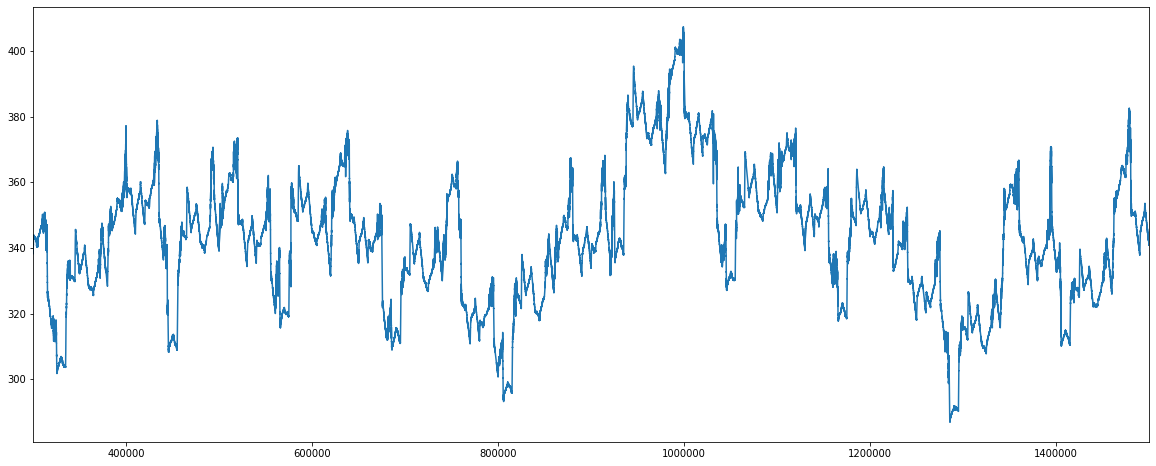

bef. devset len: 249965
devset len: 250000
trainset len: 1000000
full len: 1499965
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\17\synthetic3_train.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\17synthetic3_train.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\17\synthetic3_devset.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\17synthetic3_devset.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -class

C:\Users\suare\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\17\synthetic3_mahalanobis_state_1.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\17\synthetic3_mahalanobis_state_1.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\17\synthetic3_mahalanobis_state_2.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\17\synthetic3_mahalanobis_state_2.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspa

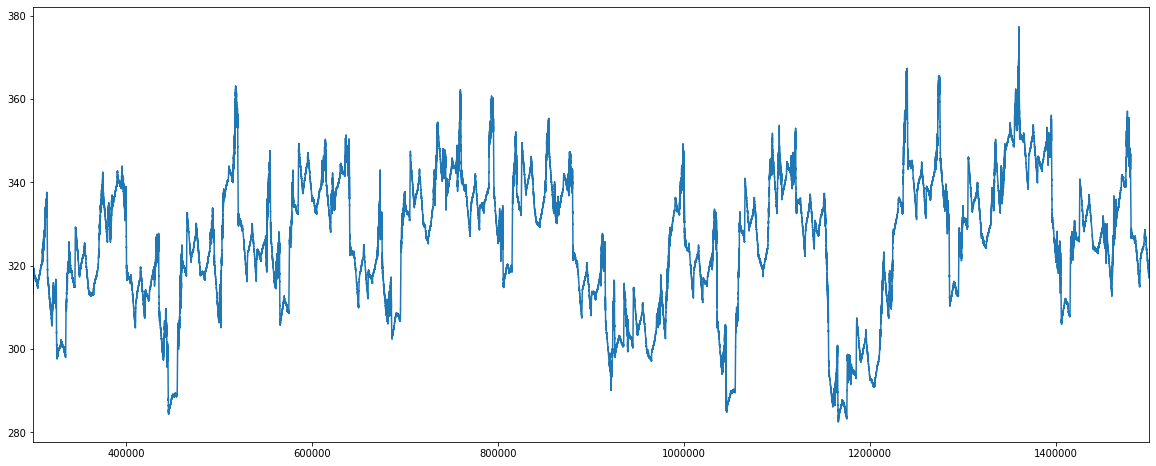

bef. devset len: 249965
devset len: 250000
trainset len: 1000000
full len: 1499965
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\18\synthetic3_train.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\18synthetic3_train.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\18\synthetic3_devset.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\18synthetic3_devset.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -class

C:\Users\suare\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\18\synthetic3_mahalanobis_state_1.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\18\synthetic3_mahalanobis_state_1.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\18\synthetic3_mahalanobis_state_2.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\18\synthetic3_mahalanobis_state_2.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspa

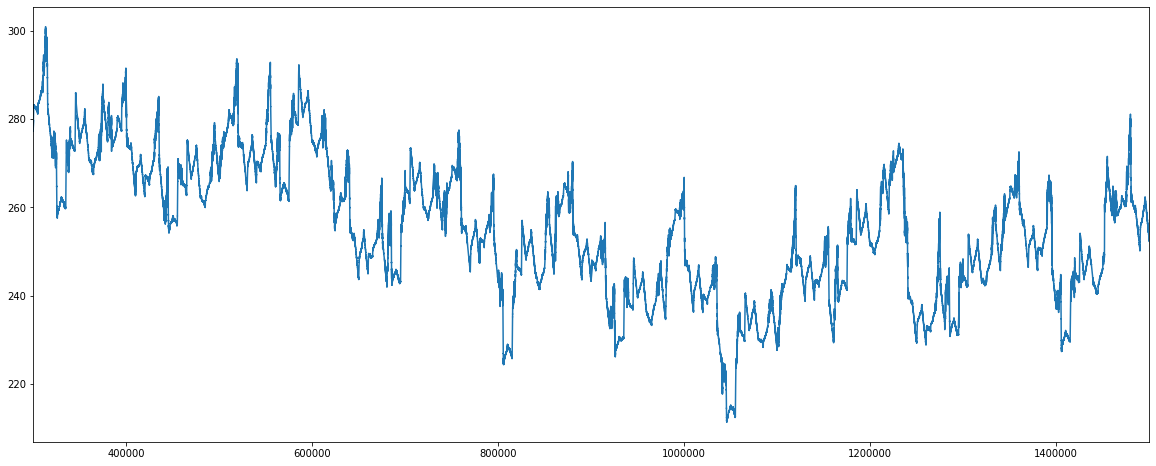

bef. devset len: 249965
devset len: 250000
trainset len: 1000000
full len: 1499965
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\19\synthetic3_train.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\19synthetic3_train.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\19\synthetic3_devset.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\19synthetic3_devset.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -class

C:\Users\suare\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\19\synthetic3_mahalanobis_state_1.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\19\synthetic3_mahalanobis_state_1.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\19\synthetic3_mahalanobis_state_2.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\19\synthetic3_mahalanobis_state_2.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspa

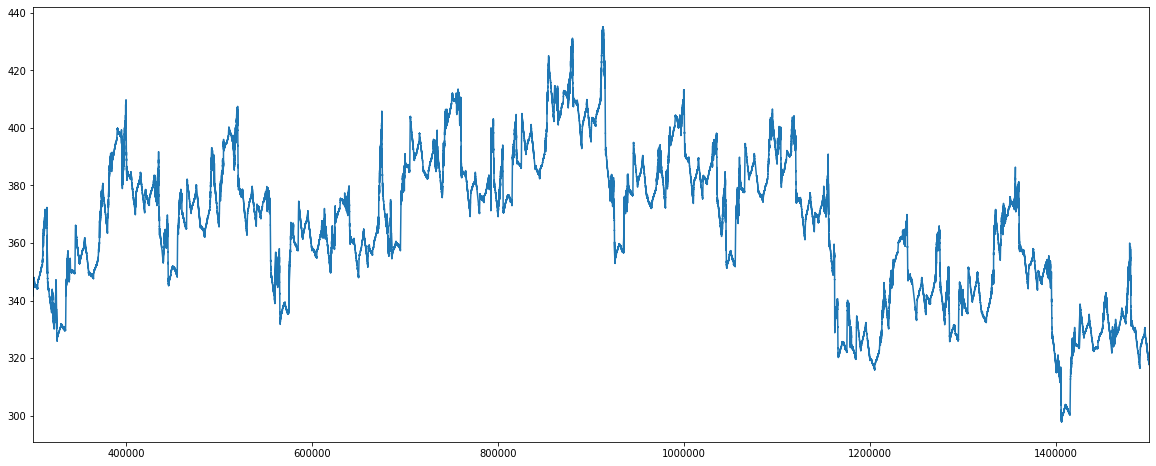

bef. devset len: 249965
devset len: 250000
trainset len: 1000000
full len: 1499965
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\2\synthetic3_train.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\2synthetic3_train.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\2\synthetic3_devset.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\2synthetic3_devset.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath

C:\Users\suare\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\2\synthetic3_mahalanobis_state_1.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\2\synthetic3_mahalanobis_state_1.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\2\synthetic3_mahalanobis_state_2.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\2\synthetic3_mahalanobis_state_2.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\p

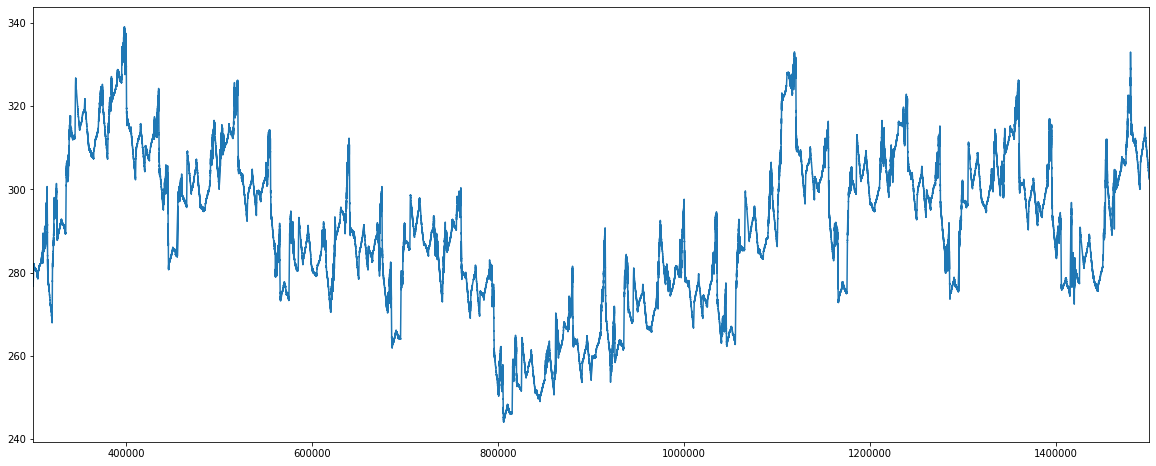

bef. devset len: 249965
devset len: 250000
trainset len: 1000000
full len: 1499965
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\20\synthetic3_train.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\20synthetic3_train.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\20\synthetic3_devset.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\20synthetic3_devset.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -class

C:\Users\suare\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\20\synthetic3_mahalanobis_state_1.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\20\synthetic3_mahalanobis_state_1.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\20\synthetic3_mahalanobis_state_2.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\20\synthetic3_mahalanobis_state_2.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspa

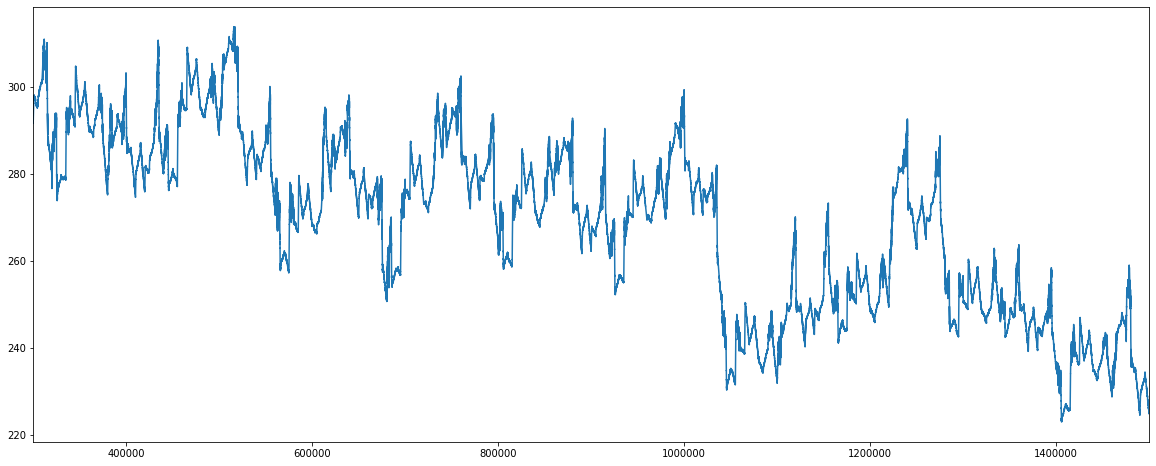

bef. devset len: 249965
devset len: 250000
trainset len: 1000000
full len: 1499965
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\21\synthetic3_train.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\21synthetic3_train.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\21\synthetic3_devset.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\21synthetic3_devset.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -class

C:\Users\suare\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\21\synthetic3_mahalanobis_state_1.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\21\synthetic3_mahalanobis_state_1.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\21\synthetic3_mahalanobis_state_2.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\21\synthetic3_mahalanobis_state_2.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspa

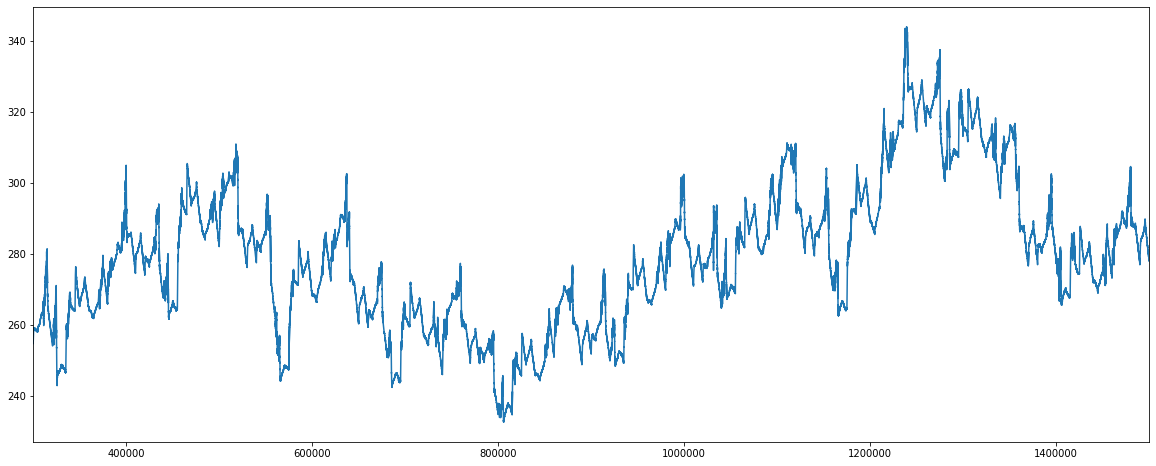

bef. devset len: 249965
devset len: 250000
trainset len: 1000000
full len: 1499965
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\22\synthetic3_train.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\22synthetic3_train.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\22\synthetic3_devset.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\22synthetic3_devset.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -class

C:\Users\suare\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\22\synthetic3_mahalanobis_state_1.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\22\synthetic3_mahalanobis_state_1.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\22\synthetic3_mahalanobis_state_2.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\22\synthetic3_mahalanobis_state_2.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspa

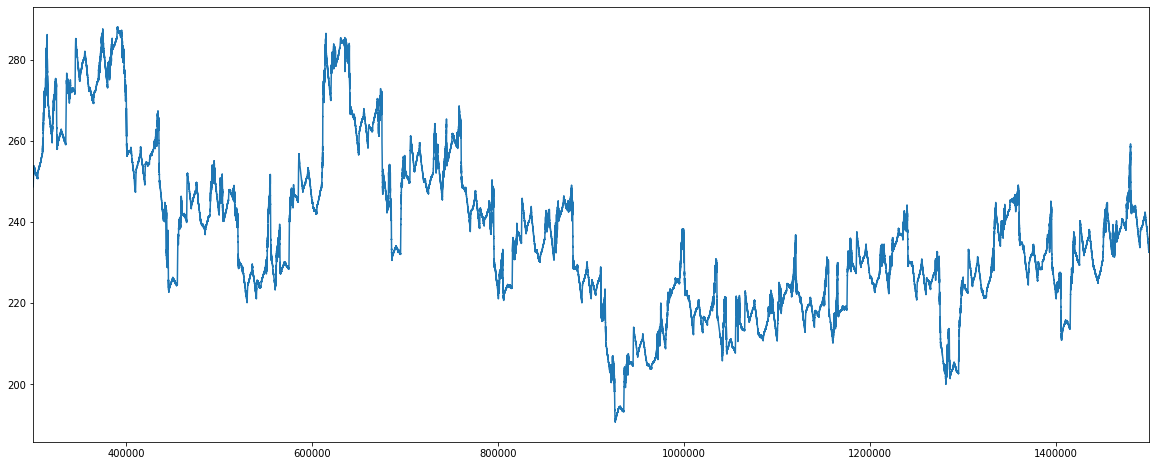

bef. devset len: 249965
devset len: 250000
trainset len: 1000000
full len: 1499965
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\23\synthetic3_train.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\23synthetic3_train.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\23\synthetic3_devset.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\23synthetic3_devset.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -class

C:\Users\suare\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\23\synthetic3_mahalanobis_state_1.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\23\synthetic3_mahalanobis_state_1.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\23\synthetic3_mahalanobis_state_2.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\23\synthetic3_mahalanobis_state_2.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspa

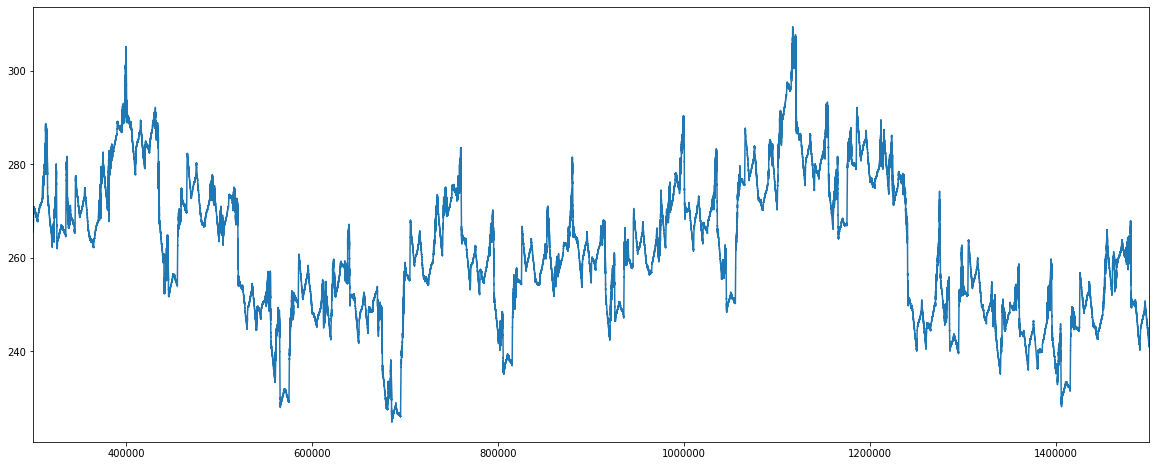

bef. devset len: 249965
devset len: 250000
trainset len: 1000000
full len: 1499965
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\24\synthetic3_train.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\24synthetic3_train.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\24\synthetic3_devset.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\24synthetic3_devset.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -class

C:\Users\suare\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\24\synthetic3_mahalanobis_state_1.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\24\synthetic3_mahalanobis_state_1.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\24\synthetic3_mahalanobis_state_2.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\24\synthetic3_mahalanobis_state_2.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspa

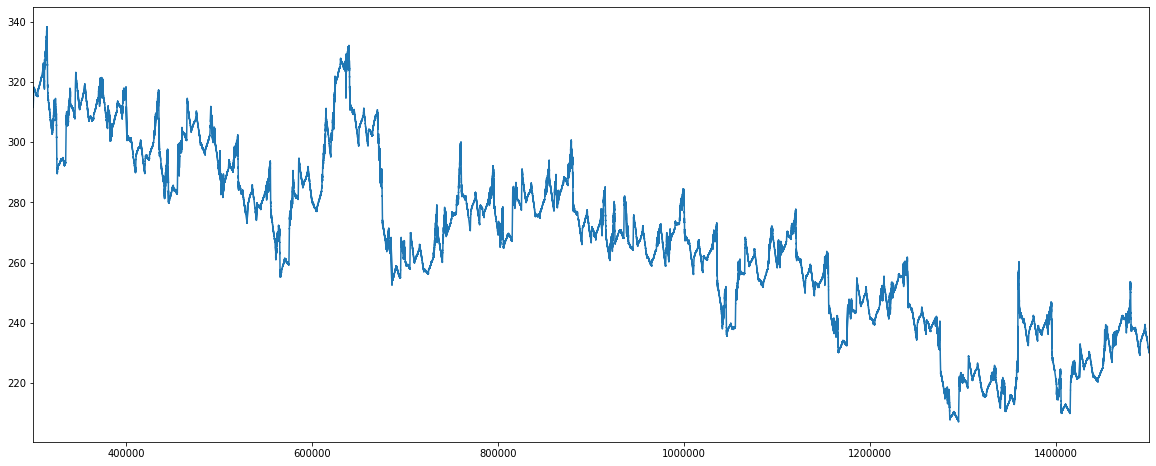

bef. devset len: 249965
devset len: 250000
trainset len: 1000000
full len: 1499965
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\25\synthetic3_train.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\25synthetic3_train.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\25\synthetic3_devset.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\25synthetic3_devset.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -class

C:\Users\suare\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\25\synthetic3_mahalanobis_state_1.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\25\synthetic3_mahalanobis_state_1.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\25\synthetic3_mahalanobis_state_2.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\25\synthetic3_mahalanobis_state_2.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspa

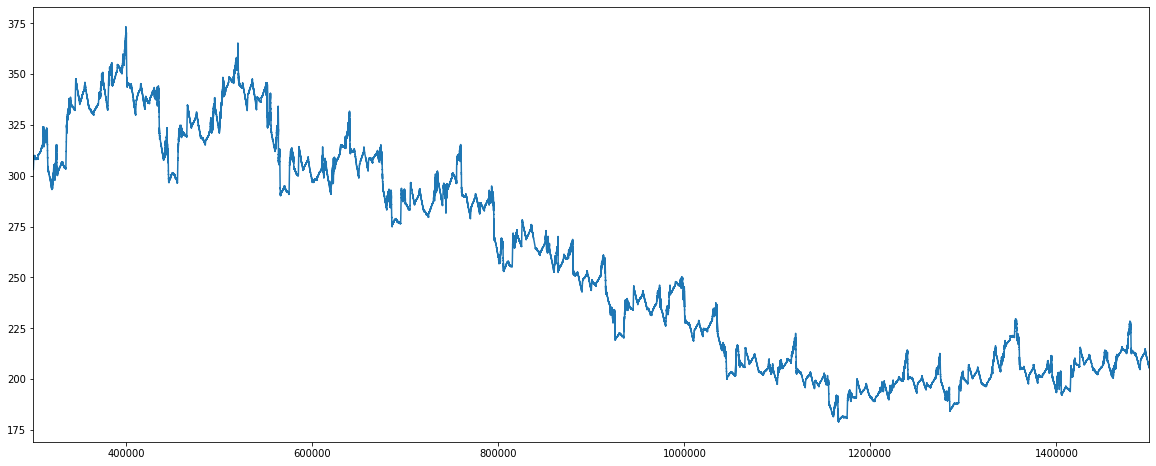

bef. devset len: 249965
devset len: 250000
trainset len: 1000000
full len: 1499965
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\26\synthetic3_train.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\26synthetic3_train.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\26\synthetic3_devset.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\26synthetic3_devset.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -class

C:\Users\suare\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\26\synthetic3_mahalanobis_state_1.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\26\synthetic3_mahalanobis_state_1.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\26\synthetic3_mahalanobis_state_2.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\26\synthetic3_mahalanobis_state_2.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspa

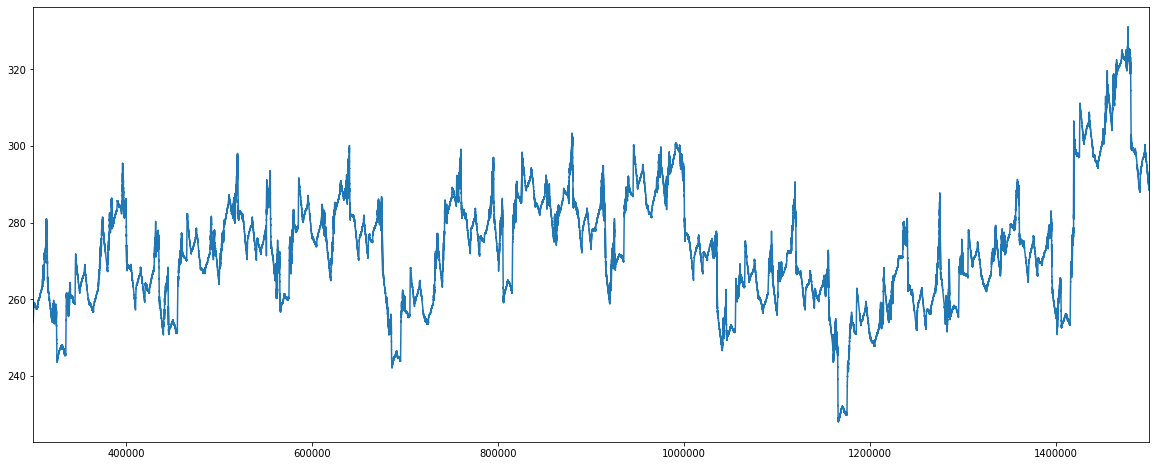

bef. devset len: 249965
devset len: 250000
trainset len: 1000000
full len: 1499965
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\27\synthetic3_train.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\27synthetic3_train.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\27\synthetic3_devset.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\27synthetic3_devset.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -class

C:\Users\suare\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\27\synthetic3_mahalanobis_state_1.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\27\synthetic3_mahalanobis_state_1.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\27\synthetic3_mahalanobis_state_2.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\27\synthetic3_mahalanobis_state_2.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspa

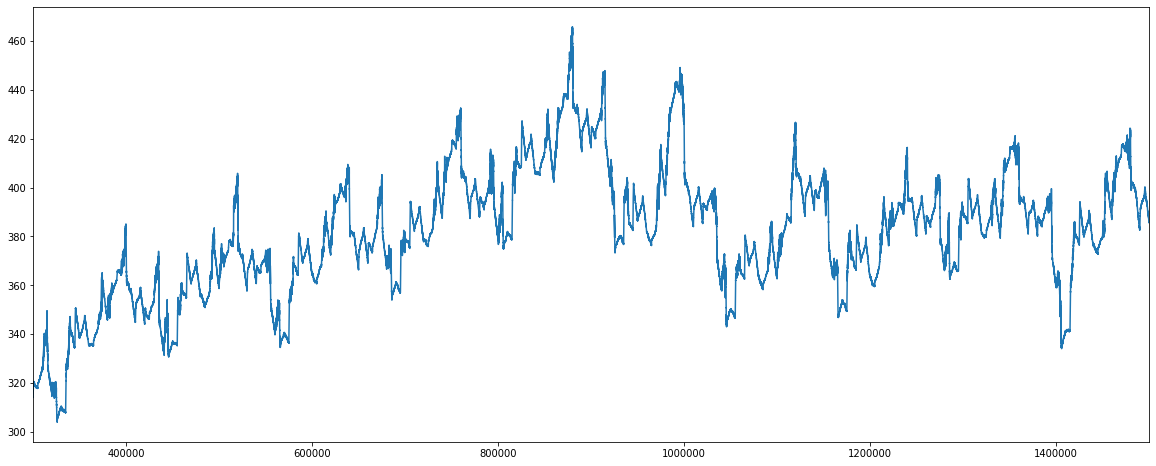

bef. devset len: 249965
devset len: 250000
trainset len: 1000000
full len: 1499965
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\28\synthetic3_train.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\28synthetic3_train.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\28\synthetic3_devset.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\28synthetic3_devset.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -class

C:\Users\suare\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\28\synthetic3_mahalanobis_state_1.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\28\synthetic3_mahalanobis_state_1.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\28\synthetic3_mahalanobis_state_2.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\28\synthetic3_mahalanobis_state_2.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspa

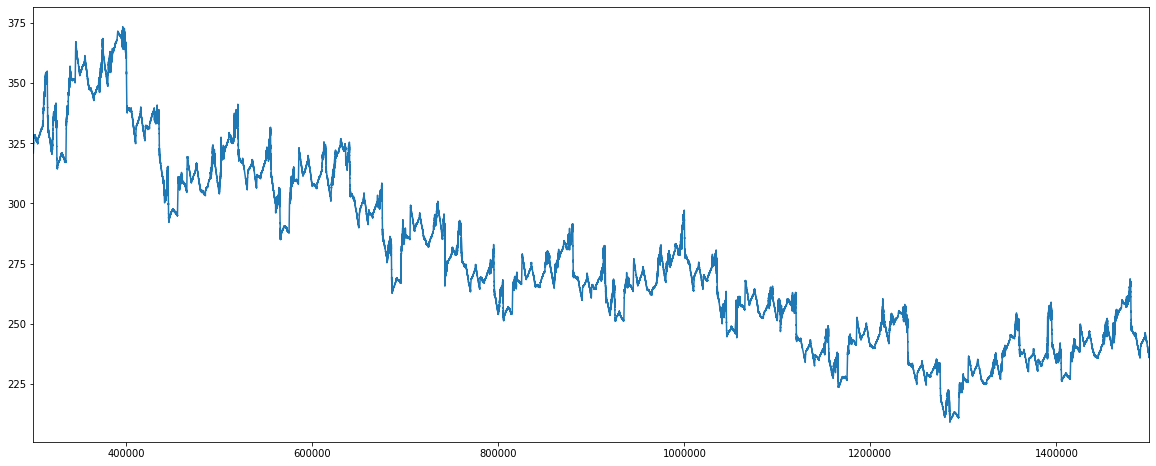

bef. devset len: 249965
devset len: 250000
trainset len: 1000000
full len: 1499965
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\29\synthetic3_train.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\29synthetic3_train.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\29\synthetic3_devset.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\29synthetic3_devset.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -class

C:\Users\suare\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\29\synthetic3_mahalanobis_state_1.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\29\synthetic3_mahalanobis_state_1.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\29\synthetic3_mahalanobis_state_2.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\29\synthetic3_mahalanobis_state_2.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspa

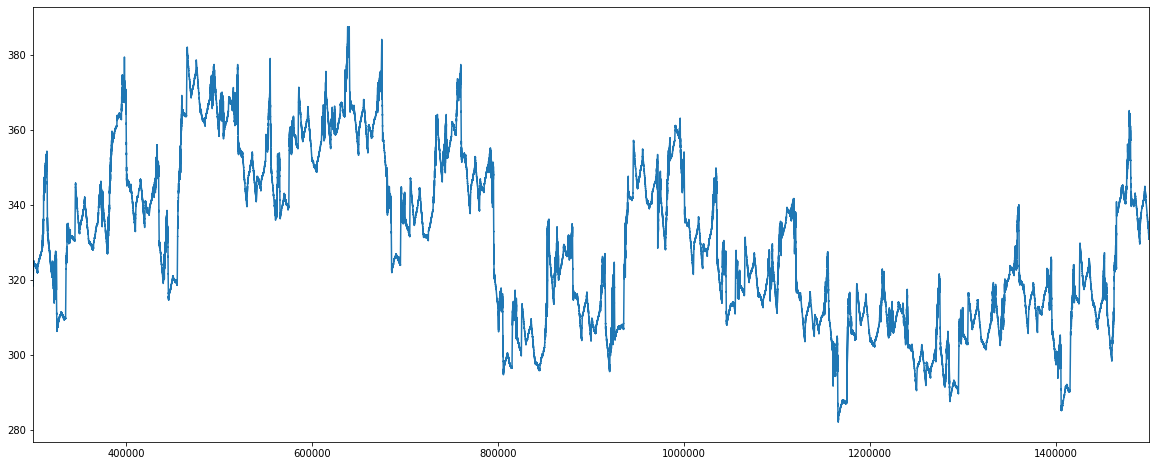

bef. devset len: 249965
devset len: 250000
trainset len: 1000000
full len: 1499965
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\3\synthetic3_train.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\3synthetic3_train.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\3\synthetic3_devset.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\3synthetic3_devset.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath

C:\Users\suare\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\3\synthetic3_mahalanobis_state_1.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\3\synthetic3_mahalanobis_state_1.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\3\synthetic3_mahalanobis_state_2.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\3\synthetic3_mahalanobis_state_2.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\p

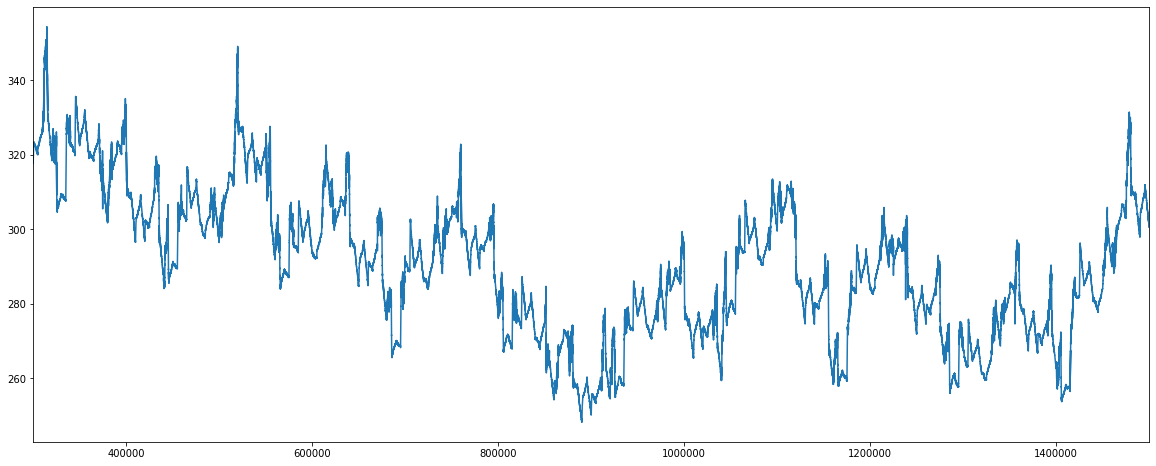

bef. devset len: 249965
devset len: 250000
trainset len: 1000000
full len: 1499965
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\30\synthetic3_train.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\30synthetic3_train.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\30\synthetic3_devset.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\30synthetic3_devset.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -class

C:\Users\suare\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\30\synthetic3_mahalanobis_state_1.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\30\synthetic3_mahalanobis_state_1.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\30\synthetic3_mahalanobis_state_2.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\30\synthetic3_mahalanobis_state_2.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspa

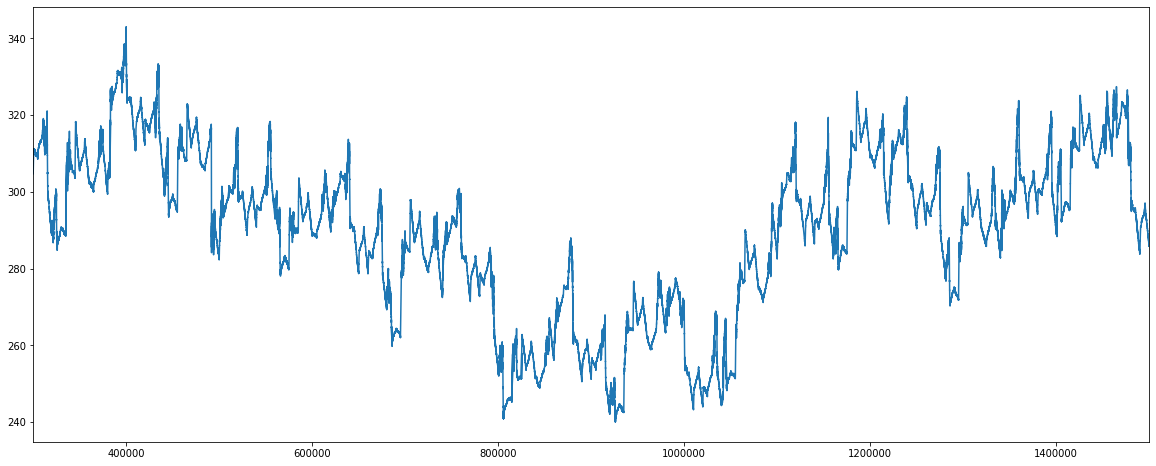

bef. devset len: 249965
devset len: 250000
trainset len: 1000000
full len: 1499965
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\31\synthetic3_train.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\31synthetic3_train.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\31\synthetic3_devset.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\31synthetic3_devset.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -class

C:\Users\suare\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\31\synthetic3_mahalanobis_state_1.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\31\synthetic3_mahalanobis_state_1.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\31\synthetic3_mahalanobis_state_2.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\31\synthetic3_mahalanobis_state_2.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspa

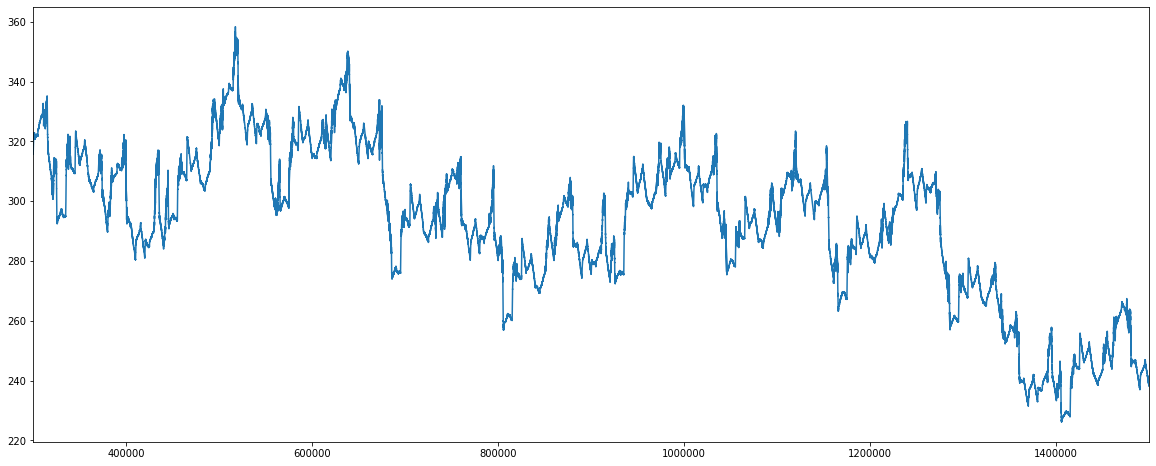

bef. devset len: 249965
devset len: 250000
trainset len: 1000000
full len: 1499965
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\4\synthetic3_train.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\4synthetic3_train.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\4\synthetic3_devset.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\4synthetic3_devset.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath

C:\Users\suare\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\4\synthetic3_mahalanobis_state_1.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\4\synthetic3_mahalanobis_state_1.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\4\synthetic3_mahalanobis_state_2.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\4\synthetic3_mahalanobis_state_2.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\p

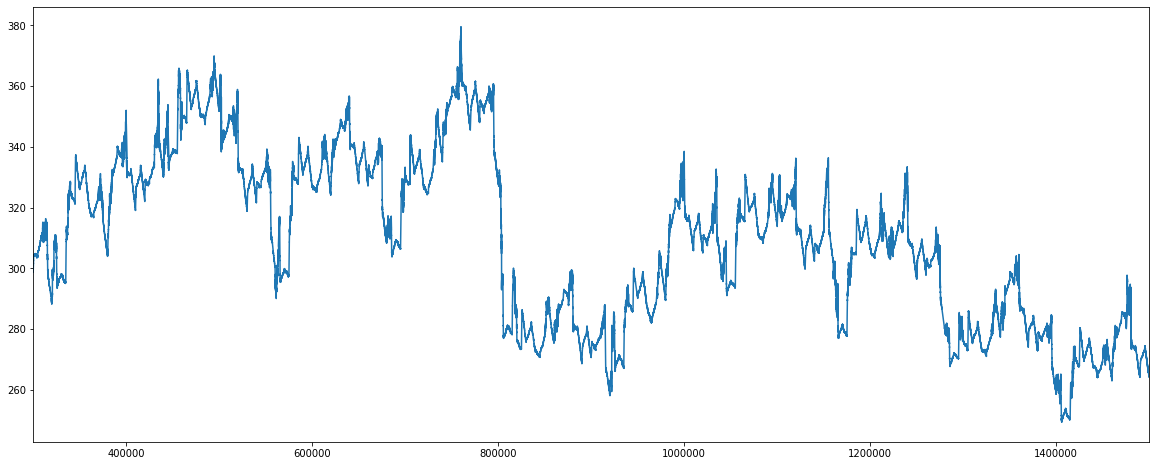

bef. devset len: 249965
devset len: 250000
trainset len: 1000000
full len: 1499965
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\5\synthetic3_train.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\5synthetic3_train.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\5\synthetic3_devset.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\5synthetic3_devset.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath

C:\Users\suare\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\5\synthetic3_mahalanobis_state_1.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\5\synthetic3_mahalanobis_state_1.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\5\synthetic3_mahalanobis_state_2.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\5\synthetic3_mahalanobis_state_2.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\p

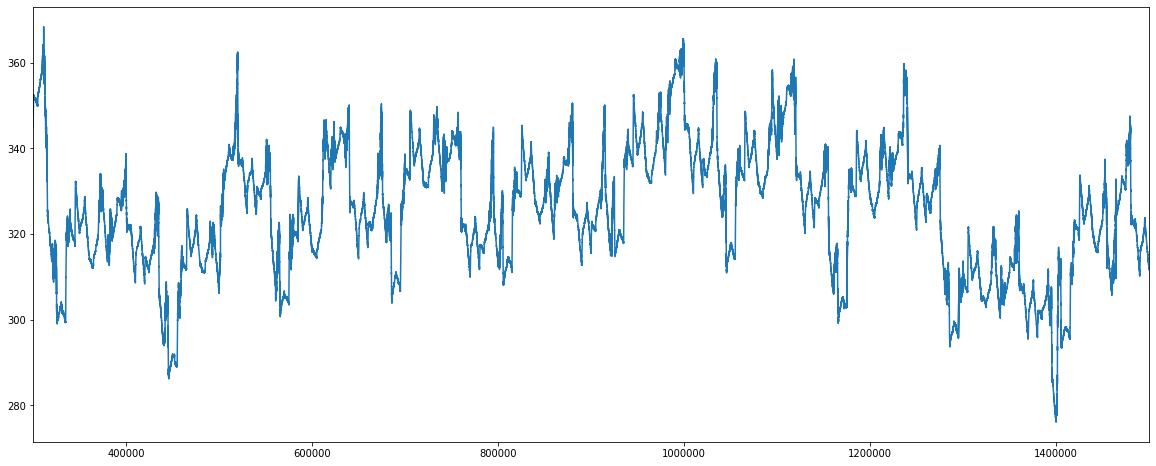

bef. devset len: 249965
devset len: 250000
trainset len: 1000000
full len: 1499965
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\6\synthetic3_train.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\6synthetic3_train.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\6\synthetic3_devset.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\6synthetic3_devset.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath

C:\Users\suare\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\6\synthetic3_mahalanobis_state_1.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\6\synthetic3_mahalanobis_state_1.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\6\synthetic3_mahalanobis_state_2.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\6\synthetic3_mahalanobis_state_2.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\p

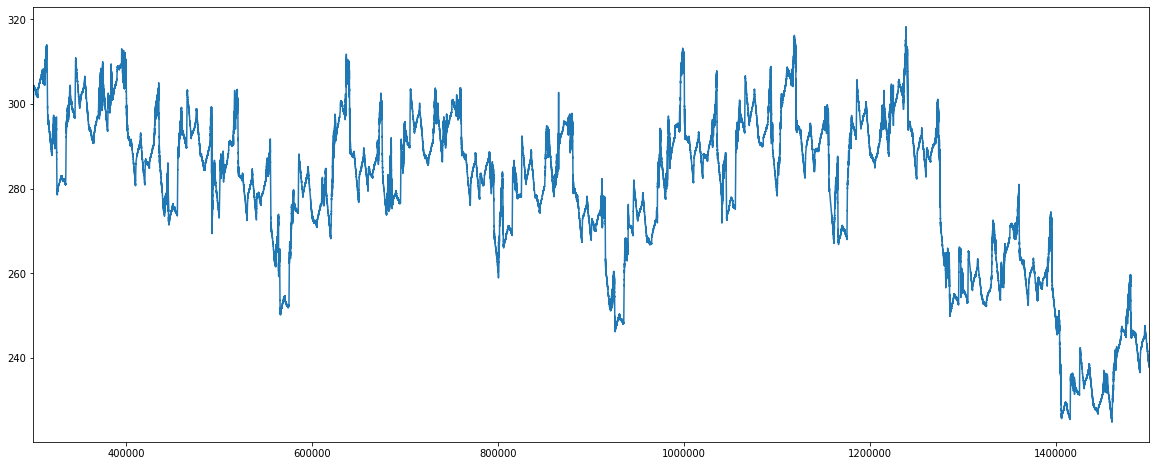

bef. devset len: 249965
devset len: 250000
trainset len: 1000000
full len: 1499965
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\7\synthetic3_train.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\7synthetic3_train.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\7\synthetic3_devset.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\7synthetic3_devset.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath

C:\Users\suare\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\7\synthetic3_mahalanobis_state_1.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\7\synthetic3_mahalanobis_state_1.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\7\synthetic3_mahalanobis_state_2.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\7\synthetic3_mahalanobis_state_2.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\p

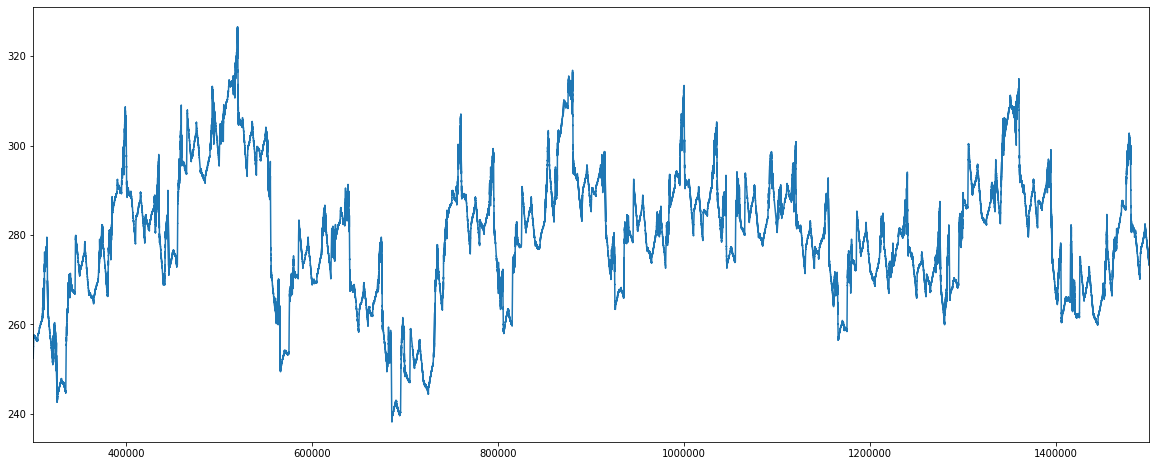

bef. devset len: 249965
devset len: 250000
trainset len: 1000000
full len: 1499965
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\8\synthetic3_train.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\8synthetic3_train.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\8\synthetic3_devset.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\8synthetic3_devset.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath

C:\Users\suare\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\8\synthetic3_mahalanobis_state_1.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\8\synthetic3_mahalanobis_state_1.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\8\synthetic3_mahalanobis_state_2.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\8\synthetic3_mahalanobis_state_2.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\p

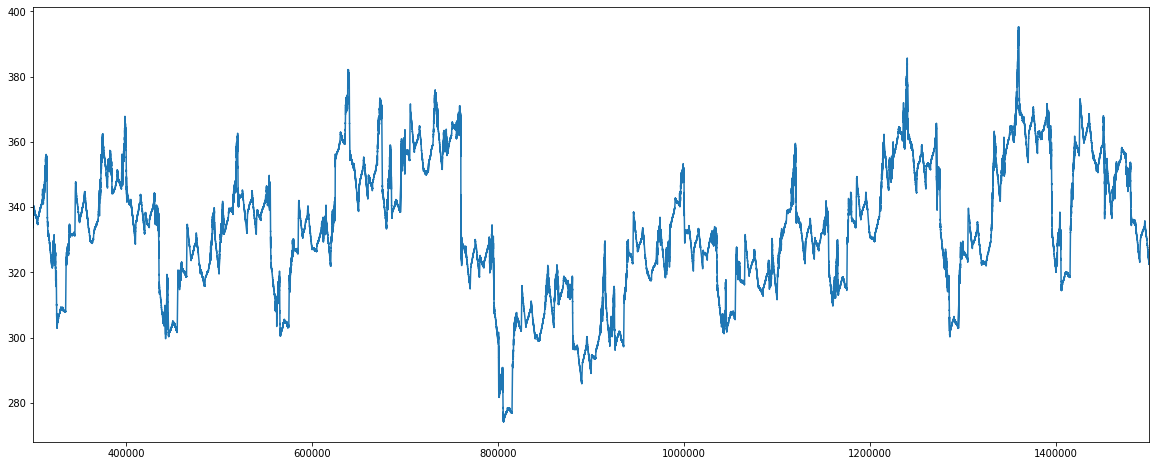

bef. devset len: 249965
devset len: 250000
trainset len: 1000000
full len: 1499965
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\9\synthetic3_train.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\9synthetic3_train.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\9\synthetic3_devset.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\9synthetic3_devset.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath

C:\Users\suare\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\9\synthetic3_mahalanobis_state_1.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\9\synthetic3_mahalanobis_state_1.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\9\synthetic3_mahalanobis_state_2.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\9\synthetic3_mahalanobis_state_2.arff
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\p

<Figure size 432x288 with 0 Axes>

In [22]:
fullset = False

# for full_set in [False, True]:
for seed in files:        
    # Paths for symbols (not eft)
    SOURCE_PATH=RESULT_PATH=DATA_PATH=seed['DATA_PATH']

    # List of dates for files to be loaded
    filename = seed['filename'] # seeds synthetic 3
    FIELD = 'ts' # price->'ts' returns->'ret_ts' ts_with_added_noise-> 'ts_n2_post'

    file = os.sep.join([SOURCE_PATH, filename+'.csv'])
    RESULT_FILEPATH_PROCESSED = os.sep.join([RESULT_PATH, filename+'_indicators.csv'])

    print(f'{SOURCE_PATH.split(os.sep)[-1]} - {filename}')

    df=pd.read_csv(file)
    df.tail(1200000).ts.plot(figsize=(20,8))
    plt.show();

    # synthetic 3
    plt.savefig(file.split(os.sep)[-1].replace('.csv', '.pdf'))

    # Open file
    df=pd.read_csv(file)
    df['close'] = df[FIELD]
    df['open'] = df[FIELD].shift(1) # close value of previous period/row
    initial_len = len(df)
    df.dropna(inplace=True) # remove first row as open is NaN
    assert len(df) + 1 == initial_len
    df['high'] = pd.np.maximum(df['open'], df['close'])
    df['low'] = pd.np.minimum(df['open'], df['close'])
    df = df[['open','close','high','low']]
    df.head()

    #Add parameters to transform in TS
    timeseries=['close']
    #Length of the TS. How many values do we keep per serie. 
    # e.g. 1 -> t / 2 -> t,t-1 / 3 -> t,t-1,t-2 / 4 -> t,t-1,t-2,t-3
    length = 5

    # Add lagged times
    for column in timeseries:
        #df[column+'_t']=df[column]
        for i in range(1,length):
            df[column+'_t-'+str(i)]=df[column].shift(i) #it could also be sorted and group by if needed
        #del drops the delected df column
        #del df[column]
    df.head()

    # all the numbers here and below assume a default time period for ta params of 10 mins averages
    # change the other numbers (params of 5min and 20min and theremoval of 20 first mins of the day below) if the mins number is changed.
    # in that case change as well the time tag '_10' with the corresponding one.
    default_timerange=10
    # Set extra timeranges for moving averages
    extra_timeranges=[default_timerange/2, default_timerange, default_timerange*2, default_timerange*3]

    # ###########################################
    # Iterate and run list of indicators selected
    # All of them produced for 25 prior mins of data 
    # ###########################################
    for ind in list(indicators):
        if ind not in ['adosc', 'obv', 'mfi']:  # avoiding indicators that need volume
            # For indicators that only return one column (this will need to be modified depending on the selection of indicators)
            if ind in ['ema','sma','trima']:
                for timerange in extra_timeranges:
                    df[ind+'_'+str(int(timerange))] = get_indicator(ind)(df, timeperiod=timerange) 
            elif ind not in ['bbands','aroon','stoch','macd','macdfix','stochf']:
                df[ind+'_'+str(int(default_timerange))] = get_indicator(ind)(df, timeperiod=(default_timerange))
            # Otherwise check the list of columns and return all
            else: 
                key_output=get_indicator(ind)(df, timeperiod=(default_timerange)) #, price='close')
                for j in range(0,len(list(key_output.columns))):
                    df[ind+'_'+key_output.columns[int(j)]] = key_output[key_output.columns[j]]
    df.head()

    def set_label(row):
        if row['close_t+1'] > row['close']: return 1
        else: return 0

    # One minute ahead closing price
    df['close_t+1']=df['close'].shift(-1)

    # Creating label/y to be predicted / independent (predicted) feature 'y' 
    df['label'] = df.apply(set_label, axis=1)
    # df.drop(columns=['n_row', 'new_switch', 'cur_switch', 'current_model_id', 'new_model_id', 
    #                  'weights', 'ts', 'ret_ts', 'ts_n1_pre', 'ts_n2_pre', 'ts_n1_post', 'ts_n2_post'], inplace=True)
    # df = df[26000:]
    df.dropna(inplace=True)
    df.head()

    # Select columns for output
    # columns_selected=['rsi_10' ,'mom_10','ema_10','ema_20','ema_30',
    #                  'sma_10','sma_20','sma_30','wma_10','wma_20','wma_30',
    #                  'trima_10','trima_20','trima_30',
    #                  'roc_10','rocr_10','ppo_10',
    #                  'close','close_t-1','close_t-2','close_t-3','close_t-4',
    #                  'label']
    # df['label'] = df['binary_label']

    if fullset:
        RESULT_FILEPATH_PROCESSED = os.sep.join([RESULT_PATH, filename.split(os.sep)[-1].replace('.csv','')+'_fullset.csv'])
        columns_selected=[# 'datetime',
                         'rsi_10','willr_10','macd_macd' ,'cci_10','mom_10',
                         'stoch_slowk','stoch_slowd',
                         'sma_5','sma_10','sma_20','sma_30',
                         'wma_5','wma_10','wma_20','wma_30',
                         'ema_5','ema_10','ema_20','ema_30',
                         'trima_5','trima_10','trima_20','trima_30',
                         'adx_10','bbands_upperband','bbands_middleband','bbands_lowerband',
                         'roc_10','rocr_10','stochf_fastd','stochf_fastk',
                         'aroon_aroondown','aroon_aroonup','medprice_10','typprice_10','wclprice_10',
                         'atr_10','macdfix_macd','sar_10',
                         'adosc_10', 'obv_10', 'mfi_10', 'ppo_10', ########## commented out previosly
                         'volume','volume_t-1','volume_t-2','volume_t-3','volume_t-4',
                         'close','close_t-1','close_t-2','close_t-3','close_t-4',
                         'high','high_t-1','high_t-2','high_t-3','high_t-4',
                         'open','open_t-1','open_t-2','open_t-3','open_t-4',
                         'low','low_t-1','low_t-2','low_t-3','low_t-4',
                         # 'binary_label',
                         'label'] #,'gap_t+1','close_t+1'] # + ['adosc_10', 'obv_10', 'mfi_10', 'ppo_10']

        output = pd.DataFrame(df, columns=columns_selected)

    else:  # the ones used with the synthetic set due to the lack of volumes also
        RESULT_FILEPATH_PROCESSED = os.sep.join([RESULT_PATH, filename.split(os.sep)[-1].replace('.csv','')+'_indicators_best.csv'])
        # best pool found through indicators grid search script
        columns_selected = ['rsi_10','willr_10','macd_macd','cci_10','mom_10','stoch_slowk','stoch_slowd','sma_5','sma_10',
                            'wma_10','ema_10','trima_10','adx_10','bbands_upperband','bbands_lowerband','roc_10',
                            'aroon_aroondown','aroon_aroonup','label']

        # Export processed data
        output = pd.DataFrame(df, columns=columns_selected)
        
        trainset = output.tail(1000000)
        devset = output.tail(1250000).head(250000)
        before_devset = output[:-1250000]
        print(f'bef. devset len: {len(before_devset)}')
        print(f'devset len: {len(devset)}')
        print(f'trainset len: {len(trainset)}')    
        print(f'full len: {len(output)}')
        assert len(output) == (len(trainset)+len(devset)+len(before_devset)), "Are the devsets properly substracted from the full set?"
        trainset.to_csv(os.sep.join([DATA_PATH, 'synthetic3_train.csv']), sep=',', encoding='utf-8', index = False)
        devset.to_csv(os.sep.join([DATA_PATH, 'synthetic3_devset.csv']), sep=',', encoding='utf-8', index = False)
        before_devset.to_csv(os.sep.join([DATA_PATH, 'synthetic3_before_dev.csv']), sep=',', encoding='utf-8', index = False)
        create_arff_file(os.sep.join([DATA_PATH, 'synthetic3_train.csv']), output=os.sep.join([DATA_PATH +'synthetic3_train'])) # export in ARFF
        create_arff_file(os.sep.join([DATA_PATH, 'synthetic3_devset.csv']), output=os.sep.join([DATA_PATH +'synthetic3_devset.csv'])) # export in ARFF
        create_arff_file(os.sep.join([DATA_PATH, 'synthetic3_before_dev.csv']), output=os.sep.join([DATA_PATH +'synthetic3_before_dev.csv'])) # export in ARFF
        
        # Mahalanobis sets
        state1_df = before_devset[:1000]
        state2_df = before_devset[7000:8000]
        state3_df = before_devset[13000:14000]
        state4_df = before_devset[18000:19000]
        i = 1
        for df1 in [state1_df, state2_df, state3_df, state4_df]:
            FILE_NAME = os.sep.join([DATA_PATH, f'synthetic3_mahalanobis_state_{i}.csv'])
            df1.label = df1.label.astype(int)
            df1.to_csv(FILE_NAME, sep=',', encoding='utf-8', index = False)
            create_arff_file(FILE_NAME) 
            i = i +1                   

                          
#   crypto_path = 'C:\\Users\\suare\\Workspace\\phd_cetrulin\\moa-2017.06-sources\\data\\real\\real_crypto\\'

    output.to_csv(RESULT_FILEPATH_PROCESSED, sep=',', encoding='utf-8', index = False)
    create_arff_file(RESULT_FILEPATH_PROCESSED, output=DATA_PATH+RESULT_FILEPATH_PROCESSED.split(os.sep)[-1]) # export in ARFF

    # Printing classes distributions
    print("Class distribution: ")
    label_zero=len(df[df['label'] == 0])
    label_one=len(df[df['label'] == 1])
    #print(label_zero)
    #print(label_one)
    print("0 in "+str(float(label_zero)/(label_one+label_zero))+"%")
    print("1 in "+str(float(label_one)/(label_one+label_zero))+"%")

    print('#####################')
    print('#####################')
    print('')

In [23]:
%notify -m "Parsing is finished"

<IPython.core.display.Javascript object>

In [26]:
# Print a List of commands to be outputed by the terminal to replace the labels to categorical
path_synthetic_seeds = os.sep.join(['C:', 'Users', 'suare', 'Workspace', 'phd_cetrulin', 'moa-2017.06-sources', 'data', 'synthetic', 'synthetic3'])
files = list()
for file in os.listdir(path_synthetic_seeds):
    if '.' not in file:
        seed_folder = os.sep.join([path_synthetic_seeds, file])
        seed_files = os.listdir(seed_folder)
        for sf in seed_files:
            if '.arff' in sf:
                full_path = os.sep.join([path_synthetic_seeds, file, sf])
#                 print(full_path)
                print(f"!sed -i 's/^.*@attribute label numeric.*$/@attribute label {0, 1}/' {full_path}")

!sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\1\1_equities_spy20200103T1407_indicators_best.arff
!sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\1\2_fixed_pref_pff20200106T1302_indicators_best.arff
!sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\1\3_real_state_vnq20200106T1215_indicators_best.arff
!sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\1\4_inter_bonds_bwx20200106T1531_indicators_best.arff
!sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\synthetic\synthetic3\1\synthetic3_before_dev.arff


In [ ]:
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/1/1_equities_spy20200103T1407_indicators_best.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/1/2_fixed_pref_pff20200106T1302_indicators_best.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/1/3_real_state_vnq20200106T1215_indicators_best.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/1/4_inter_bonds_bwx20200106T1531_indicators_best.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/1/synthetic3_before_dev.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/1/synthetic3_devset.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/1/synthetic3_mahalanobis_state_1.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/1/synthetic3_mahalanobis_state_2.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/1/synthetic3_mahalanobis_state_3.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/1/synthetic3_mahalanobis_state_4.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/1/synthetic3_train.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/1/timeseries_created_1607572321_before_dev.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/1/timeseries_created_1607572321_devset.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/10/synthetic3_before_dev.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/10/synthetic3_devset.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/10/synthetic3_mahalanobis_state_1.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/10/synthetic3_mahalanobis_state_2.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/10/synthetic3_mahalanobis_state_3.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/10/synthetic3_mahalanobis_state_4.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/10/synthetic3_train.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/10/timeseries_created_1607444006_indicators_best.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/11/synthetic3_before_dev.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/11/synthetic3_devset.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/11/synthetic3_mahalanobis_state_1.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/11/synthetic3_mahalanobis_state_2.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/11/synthetic3_mahalanobis_state_3.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/11/synthetic3_mahalanobis_state_4.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/11/synthetic3_train.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/11/timeseries_created_1607503794_indicators_best.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/12/synthetic3_before_dev.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/12/synthetic3_devset.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/12/synthetic3_mahalanobis_state_1.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/12/synthetic3_mahalanobis_state_2.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/12/synthetic3_mahalanobis_state_3.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/12/synthetic3_mahalanobis_state_4.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/12/synthetic3_train.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/12/timeseries_created_1607518893_indicators_best.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/13/synthetic3_before_dev.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/13/synthetic3_devset.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/13/synthetic3_mahalanobis_state_1.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/13/synthetic3_mahalanobis_state_2.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/13/synthetic3_mahalanobis_state_3.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/13/synthetic3_mahalanobis_state_4.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/13/synthetic3_train.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/13/timeseries_created_1607529564_indicators_best.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/14/synthetic3_before_dev.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/14/synthetic3_devset.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/14/synthetic3_mahalanobis_state_1.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/14/synthetic3_mahalanobis_state_2.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/14/synthetic3_mahalanobis_state_3.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/14/synthetic3_mahalanobis_state_4.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/14/synthetic3_train.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/14/timeseries_created_1607580333_indicators_best.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/15/synthetic3_before_dev.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/15/synthetic3_devset.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/15/synthetic3_mahalanobis_state_1.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/15/synthetic3_mahalanobis_state_2.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/15/synthetic3_mahalanobis_state_3.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/15/synthetic3_mahalanobis_state_4.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/15/synthetic3_train.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/15/timeseries_created_1607596657_indicators_best.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/16/synthetic3_before_dev.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/16/synthetic3_devset.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/16/synthetic3_mahalanobis_state_1.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/16/synthetic3_mahalanobis_state_2.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/16/synthetic3_mahalanobis_state_3.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/16/synthetic3_mahalanobis_state_4.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/16/synthetic3_train.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/16/timeseries_created_1607604726_indicators_best.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/17/synthetic3_before_dev.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/17/synthetic3_devset.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/17/synthetic3_mahalanobis_state_1.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/17/synthetic3_mahalanobis_state_2.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/17/synthetic3_mahalanobis_state_3.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/17/synthetic3_mahalanobis_state_4.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/17/synthetic3_train.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/17/timeseries_created_1607428438_indicators_best.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/18/synthetic3_before_dev.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/18/synthetic3_devset.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/18/synthetic3_mahalanobis_state_1.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/18/synthetic3_mahalanobis_state_2.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/18/synthetic3_mahalanobis_state_3.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/18/synthetic3_mahalanobis_state_4.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/18/synthetic3_train.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/18/timeseries_created_1607653468_indicators_best.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/19/synthetic3_before_dev.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/19/synthetic3_devset.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/19/synthetic3_mahalanobis_state_1.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/19/synthetic3_mahalanobis_state_2.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/19/synthetic3_mahalanobis_state_3.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/19/synthetic3_mahalanobis_state_4.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/19/synthetic3_train.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/19/timeseries_created_1607667706_indicators_best.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/2/synthetic3_before_dev.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/2/synthetic3_devset.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/2/synthetic3_mahalanobis_state_1.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/2/synthetic3_mahalanobis_state_2.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/2/synthetic3_mahalanobis_state_3.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/2/synthetic3_mahalanobis_state_4.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/2/synthetic3_train.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/2/timeseries_created_1607428151_indicators_best.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/20/synthetic3_before_dev.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/20/synthetic3_devset.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/20/synthetic3_mahalanobis_state_1.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/20/synthetic3_mahalanobis_state_2.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/20/synthetic3_mahalanobis_state_3.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/20/synthetic3_mahalanobis_state_4.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/20/synthetic3_train.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/20/timeseries_created_1607683316_indicators_best.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/21/synthetic3_before_dev.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/21/synthetic3_devset.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/21/synthetic3_mahalanobis_state_1.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/21/synthetic3_mahalanobis_state_2.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/21/synthetic3_mahalanobis_state_3.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/21/synthetic3_mahalanobis_state_4.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/21/synthetic3_train.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/21/timeseries_created_1607606173_indicators_best.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/22/synthetic3_before_dev.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/22/synthetic3_devset.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/22/synthetic3_mahalanobis_state_1.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/22/synthetic3_mahalanobis_state_2.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/22/synthetic3_mahalanobis_state_3.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/22/synthetic3_mahalanobis_state_4.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/22/synthetic3_train.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/22/timeseries_created_1607449365_indicators_best.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/23/synthetic3_before_dev.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/23/synthetic3_devset.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/23/synthetic3_mahalanobis_state_1.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/23/synthetic3_mahalanobis_state_2.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/23/synthetic3_mahalanobis_state_3.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/23/synthetic3_mahalanobis_state_4.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/23/synthetic3_train.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/23/timeseries_created_1607645524_indicators_best.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/24/synthetic3_before_dev.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/24/synthetic3_devset.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/24/synthetic3_mahalanobis_state_1.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/24/synthetic3_mahalanobis_state_2.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/24/synthetic3_mahalanobis_state_3.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/24/synthetic3_mahalanobis_state_4.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/24/synthetic3_train.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/24/timeseries_created_1607428539_indicators_best.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/25/synthetic3_before_dev.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/25/synthetic3_devset.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/25/synthetic3_mahalanobis_state_1.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/25/synthetic3_mahalanobis_state_2.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/25/synthetic3_mahalanobis_state_3.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/25/synthetic3_mahalanobis_state_4.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/25/synthetic3_train.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/25/timeseries_created_1607430502_indicators_best.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/26/synthetic3_before_dev.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/26/synthetic3_devset.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/26/synthetic3_mahalanobis_state_1.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/26/synthetic3_mahalanobis_state_2.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/26/synthetic3_mahalanobis_state_3.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/26/synthetic3_mahalanobis_state_4.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/26/synthetic3_train.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/26/timeseries_created_1607435642_indicators_best.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/27/synthetic3_before_dev.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/27/synthetic3_devset.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/27/synthetic3_mahalanobis_state_1.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/27/synthetic3_mahalanobis_state_2.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/27/synthetic3_mahalanobis_state_3.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/27/synthetic3_mahalanobis_state_4.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/27/synthetic3_train.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/27/timeseries_created_1607441898_indicators_best.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/28/synthetic3_before_dev.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/28/synthetic3_devset.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/28/synthetic3_mahalanobis_state_1.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/28/synthetic3_mahalanobis_state_2.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/28/synthetic3_mahalanobis_state_3.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/28/synthetic3_mahalanobis_state_4.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/28/synthetic3_train.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/28/timeseries_created_1607444121_indicators_best.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/29/synthetic3_before_dev.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/29/synthetic3_devset.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/29/synthetic3_mahalanobis_state_1.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/29/synthetic3_mahalanobis_state_2.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/29/synthetic3_mahalanobis_state_3.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/29/synthetic3_mahalanobis_state_4.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/29/synthetic3_train.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/29/timeseries_created_1607444148_indicators_best.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/3/synthetic3_before_dev.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/3/synthetic3_devset.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/3/synthetic3_mahalanobis_state_1.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/3/synthetic3_mahalanobis_state_2.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/3/synthetic3_mahalanobis_state_3.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/3/synthetic3_mahalanobis_state_4.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/3/synthetic3_train.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/3/timeseries_created_1607428518_indicators_best.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/30/synthetic3_before_dev.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/30/synthetic3_devset.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/30/synthetic3_mahalanobis_state_1.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/30/synthetic3_mahalanobis_state_2.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/30/synthetic3_mahalanobis_state_3.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/30/synthetic3_mahalanobis_state_4.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/30/synthetic3_train.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/30/timeseries_created_1607446587_indicators_best.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/31/synthetic3_before_dev.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/31/synthetic3_devset.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/31/synthetic3_mahalanobis_state_1.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/31/synthetic3_mahalanobis_state_2.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/31/synthetic3_mahalanobis_state_3.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/31/synthetic3_mahalanobis_state_4.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/31/synthetic3_train.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/31/timeseries_created_1607444260_indicators_best.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/4/synthetic3_before_dev.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/4/synthetic3_devset.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/4/synthetic3_mahalanobis_state_1.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/4/synthetic3_mahalanobis_state_2.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/4/synthetic3_mahalanobis_state_3.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/4/synthetic3_mahalanobis_state_4.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/4/synthetic3_train.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/4/timeseries_created_1607430493_indicators_best.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/5/synthetic3_before_dev.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/5/synthetic3_devset.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/5/synthetic3_mahalanobis_state_1.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/5/synthetic3_mahalanobis_state_2.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/5/synthetic3_mahalanobis_state_3.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/5/synthetic3_mahalanobis_state_4.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/5/synthetic3_train.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/5/timeseries_created_1607434427_indicators_best.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/6/synthetic3_before_dev.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/6/synthetic3_devset.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/6/synthetic3_mahalanobis_state_1.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/6/synthetic3_mahalanobis_state_2.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/6/synthetic3_mahalanobis_state_3.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/6/synthetic3_mahalanobis_state_4.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/6/synthetic3_train.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/6/timeseries_created_1607435719_indicators_best.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/7/synthetic3_before_dev.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/7/synthetic3_devset.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/7/synthetic3_mahalanobis_state_1.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/7/synthetic3_mahalanobis_state_2.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/7/synthetic3_mahalanobis_state_3.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/7/synthetic3_mahalanobis_state_4.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/7/synthetic3_train.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/7/timeseries_created_1607435916_indicators_best.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/8/synthetic3_before_dev.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/8/synthetic3_devset.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/8/synthetic3_mahalanobis_state_1.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/8/synthetic3_mahalanobis_state_2.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/8/synthetic3_mahalanobis_state_3.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/8/synthetic3_mahalanobis_state_4.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/8/synthetic3_train.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/8/timeseries_created_1607438218_indicators_best.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/9/synthetic3_before_dev.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/9/synthetic3_devset.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/9/synthetic3_mahalanobis_state_1.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/9/synthetic3_mahalanobis_state_2.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/9/synthetic3_mahalanobis_state_3.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/9/synthetic3_mahalanobis_state_4.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/9/synthetic3_train.arff
sed -i 's/^.*@attribute label numeric.*$/@attribute label (0, 1)/' $MOA_DEV/data/synthetic/synthetic3/9/timeseries_created_1607438240_indicators_best.arff

# Individual processing (2020)

In [68]:
# Paths
# Paths for symbols (not eft)
# DATA_PATH=os.sep.join(['C:','Users','suare','PycharmProjects','RegimeSwitchingSeriesGenerator','output'])
DATA_PATH=os.sep.join(['C:','Users','suare','PycharmProjects','RegimeSwitchingSeriesGenerator','output', 'synthetic3'])

# '/Users/asuarez/Downloads'
SOURCE_PATH=DATA_PATH # +'raw\\alpha_vantage\\S&P500\\symbols\\AAPL\\'  # 'raw/alpha_vantage/'
RESULT_PATH=DATA_PATH # +'analysis\\'+SYMBOL.lower()+'\\'

# List of dates for files to be loaded
# First synthetic set
# filename = 'timeseries_created_1576000391' # 'timeseries_created_1574259300' 'timeseries_created_1574272163'
# Second synthetic set
# filename = 'timeseries_created_1606044962' 
# filename  = 'timeseries_created_1607428151' # plan b synthetic3
filename  = 'timeseries_created_1607572321' # best candidate synthetic 3
FIELD = 'ts' # price->'ts' returns->'ret_ts' ts_with_added_noise-> 'ts_n2_post'

file = os.sep.join([SOURCE_PATH, filename+'.csv'])
RESULT_FILEPATH_PROCESSED = os.sep.join([RESULT_PATH, filename+'_indicators.csv'])

In [54]:
file

'C:\\Users\\suare\\PycharmProjects\\RegimeSwitchingSeriesGenerator\\output\\synthetic3\\timeseries_created_1607572321.csv'

<AxesSubplot:>

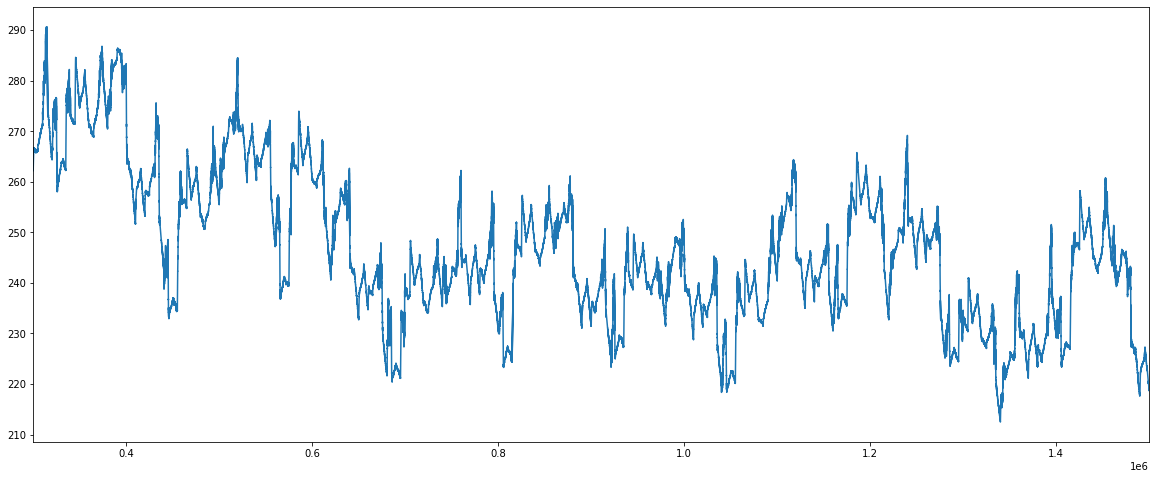

In [55]:
df=pd.read_csv(file)
df.tail(1200000).ts.plot(figsize=(20,8))
# synthetic 3

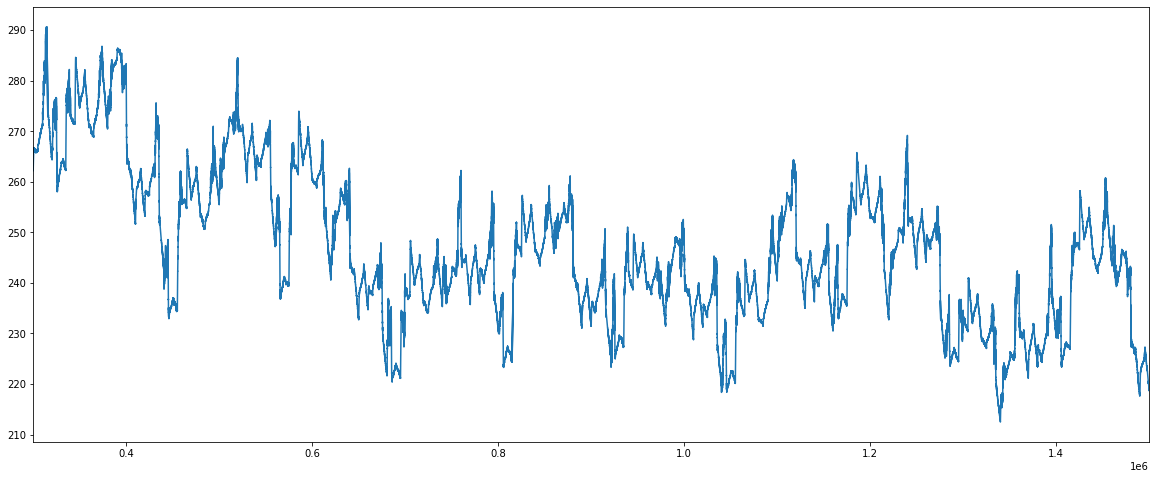

In [69]:
df=pd.read_csv(file)
df.tail(1200000).ts.plot(figsize=(20,8))
plt.savefig(file.split(os.sep)[-1].replace('.csv', '.pdf'))
# plan b

In [56]:
# Open file
df=pd.read_csv(file)
df['close'] = df[FIELD]
df['open'] = df[FIELD].shift(1) # close value of previous period/row
initial_len = len(df)
df.dropna(inplace=True) # remove first row as open is NaN
assert len(df) + 1 == initial_len
df['high'] = pd.np.maximum(df['open'], df['close'])
df['low'] = pd.np.minimum(df['open'], df['close'])
df = df[['open','close','high','low']]
df.head()

,open,close,high,low
1,319.554231,319.500954,319.554231,319.500954
2,319.500954,319.500577,319.500954,319.500577
3,319.500577,319.510620,319.510620,319.500577
4,319.510620,319.489107,319.510620,319.489107
5,319.489107,319.515416,319.515416,319.489107


In [57]:
#Add parameters to transform in TS
timeseries=['close']
#Length of the TS. How many values do we keep per serie. 
# e.g. 1 -> t / 2 -> t,t-1 / 3 -> t,t-1,t-2 / 4 -> t,t-1,t-2,t-3
length = 5

# Add lagged times
for column in timeseries:
    #df[column+'_t']=df[column]
    for i in range(1,length):
        df[column+'_t-'+str(i)]=df[column].shift(i) #it could also be sorted and group by if needed
    #del drops the delected df column
    #del df[column]
df.head()

,open,close,high,low,close_t-1,close_t-2,close_t-3,close_t-4
1,319.554231,319.500954,319.554231,319.500954,NaN,NaN,NaN,NaN
2,319.500954,319.500577,319.500954,319.500577,319.500954,NaN,NaN,NaN
3,319.500577,319.510620,319.510620,319.500577,319.500577,319.500954,NaN,NaN
4,319.510620,319.489107,319.510620,319.489107,319.510620,319.500577,319.500954,NaN
5,319.489107,319.515416,319.515416,319.489107,319.489107,319.510620,319.500577,319.500954


In [58]:
# all the numbers here and below assume a default time period for ta params of 10 mins averages
# change the other numbers (params of 5min and 20min and theremoval of 20 first mins of the day below) if the mins number is changed.
# in that case change as well the time tag '_10' with the corresponding one.
default_timerange=10
# Set extra timeranges for moving averages
extra_timeranges=[default_timerange/2, default_timerange, default_timerange*2, default_timerange*3]

# ###########################################
# Iterate and run list of indicators selected
# All of them produced for 25 prior mins of data 
# ###########################################
for ind in list(indicators):
    if ind not in ['adosc', 'obv', 'mfi']:  # avoiding indicators that need volume
        # For indicators that only return one column (this will need to be modified depending on the selection of indicators)
        if ind in ['ema','sma','trima']:
            for timerange in extra_timeranges:
                df[ind+'_'+str(int(timerange))] = get_indicator(ind)(df, timeperiod=timerange) 
        elif ind not in ['bbands','aroon','stoch','macd','macdfix','stochf']:
            df[ind+'_'+str(int(default_timerange))] = get_indicator(ind)(df, timeperiod=(default_timerange))
        # Otherwise check the list of columns and return all
        else: 
            key_output=get_indicator(ind)(df, timeperiod=(default_timerange)) #, price='close')
            for j in range(0,len(list(key_output.columns))):
                df[ind+'_'+key_output.columns[int(j)]] = key_output[key_output.columns[j]]
df.head()

,open,close,high,low,close_t-1,close_t-2,close_t-3,close_t-4,sma_5,sma_10,...,stochf_fastd,medprice_10,typprice_10,wclprice_10,atr_10,macdfix_macd,macdfix_macdsignal,macdfix_macdhist,sar_10,ppo_10
1,319.554231,319.500954,319.554231,319.500954,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,319.527593,319.518713,319.514273,NaN,NaN,NaN,NaN,NaN,NaN
2,319.500954,319.500577,319.500954,319.500577,319.500954,NaN,NaN,NaN,NaN,NaN,...,NaN,319.500766,319.500703,319.500671,NaN,NaN,NaN,NaN,319.554231,NaN
3,319.500577,319.510620,319.510620,319.500577,319.500577,319.500954,NaN,NaN,NaN,NaN,...,NaN,319.505598,319.507272,319.508109,NaN,NaN,NaN,NaN,319.553158,NaN
4,319.510620,319.489107,319.510620,319.489107,319.510620,319.500577,319.500954,NaN,NaN,NaN,...,NaN,319.499863,319.496278,319.494485,NaN,NaN,NaN,NaN,319.552107,NaN
5,319.489107,319.515416,319.515416,319.489107,319.489107,319.510620,319.500577,319.500954,319.503335,NaN,...,NaN,319.502262,319.506646,319.508839,NaN,NaN,NaN,NaN,319.549587,NaN


In [59]:
def set_label(row):
    if row['close_t+1'] > row['close']: return 1
    else: return 0

# One minute ahead closing price
df['close_t+1']=df['close'].shift(-1)

# Creating label/y to be predicted / independent (predicted) feature 'y' 
df['label'] = df.apply(set_label, axis=1)
# df.drop(columns=['n_row', 'new_switch', 'cur_switch', 'current_model_id', 'new_model_id', 
#                  'weights', 'ts', 'ret_ts', 'ts_n1_pre', 'ts_n2_pre', 'ts_n1_post', 'ts_n2_post'], inplace=True)
# df = df[26000:]
df.dropna(inplace=True)
df.head()

,open,close,high,low,close_t-1,close_t-2,close_t-3,close_t-4,sma_5,sma_10,...,typprice_10,wclprice_10,atr_10,macdfix_macd,macdfix_macdsignal,macdfix_macdhist,sar_10,ppo_10,close_t+1,label
34,319.571935,319.567576,319.571935,319.567576,319.571935,319.539167,319.531619,319.528393,319.547738,319.529633,...,319.569029,319.568666,0.014493,0.008910,0.006461,0.002450,319.499986,-0.001344,319.546497,0
35,319.567576,319.546497,319.567576,319.546497,319.567576,319.571935,319.539167,319.531619,319.551359,319.532937,...,319.553523,319.551767,0.015152,0.008659,0.006900,0.001759,319.501425,-0.001726,319.603696,1
36,319.546497,319.603696,319.603696,319.546497,319.546497,319.567576,319.571935,319.539167,319.565774,319.541907,...,319.584629,319.589396,0.019357,0.012655,0.008051,0.004603,319.502835,-0.001114,319.556245,0
37,319.603696,319.556245,319.603696,319.556245,319.603696,319.546497,319.567576,319.571935,319.569190,319.545773,...,319.572062,319.568108,0.022166,0.012095,0.008860,0.003235,319.506869,-0.000355,319.566754,1
38,319.556245,319.566754,319.566754,319.556245,319.556245,319.603696,319.546497,319.567576,319.568154,319.552254,...,319.563251,319.564127,0.021000,0.012307,0.009549,0.002758,319.510742,0.000947,319.572879,1


In [60]:
# df = df[41200:]


In [61]:
# Select columns for output
# columns_selected=['rsi_10' ,'mom_10','ema_10','ema_20','ema_30',
#                  'sma_10','sma_20','sma_30','wma_10','wma_20','wma_30',
#                  'trima_10','trima_20','trima_30',
#                  'roc_10','rocr_10','ppo_10',
#                  'close','close_t-1','close_t-2','close_t-3','close_t-4',
#                  'label']
# df['label'] = df['binary_label']
fullset = False
if fullset:
    RESULT_FILEPATH_PROCESSED = os.sep.join([RESULT_PATH, filename.split(os.sep)[-1].replace('.csv','')+'_fullset.csv'])
    columns_selected=[# 'datetime',
                     'rsi_10','willr_10','macd_macd' ,'cci_10','mom_10',
                     'stoch_slowk','stoch_slowd',
                     'sma_5','sma_10','sma_20','sma_30',
                     'wma_5','wma_10','wma_20','wma_30',
                     'ema_5','ema_10','ema_20','ema_30',
                     'trima_5','trima_10','trima_20','trima_30',
                     'adx_10','bbands_upperband','bbands_middleband','bbands_lowerband',
                     'roc_10','rocr_10','stochf_fastd','stochf_fastk',
                     'aroon_aroondown','aroon_aroonup','medprice_10','typprice_10','wclprice_10',
                     'atr_10','macdfix_macd','sar_10',
                     'adosc_10', 'obv_10', 'mfi_10', 'ppo_10', ########## commented out previosly
                     'volume','volume_t-1','volume_t-2','volume_t-3','volume_t-4',
                     'close','close_t-1','close_t-2','close_t-3','close_t-4',
                     'high','high_t-1','high_t-2','high_t-3','high_t-4',
                     'open','open_t-1','open_t-2','open_t-3','open_t-4',
                     'low','low_t-1','low_t-2','low_t-3','low_t-4',
                     # 'binary_label',
                     'label'] #,'gap_t+1','close_t+1'] # + ['adosc_10', 'obv_10', 'mfi_10', 'ppo_10']
    
else:  # the ones used with the synthetic set due to the lack of volumes also
    RESULT_FILEPATH_PROCESSED = os.sep.join([RESULT_PATH, filename.split(os.sep)[-1].replace('.csv','')+'_indicators_best.csv'])
    # best pool found through indicators grid search script
    columns_selected = ['rsi_10','willr_10','macd_macd','cci_10','mom_10','stoch_slowk','stoch_slowd','sma_5','sma_10',
                        'wma_10','ema_10','trima_10','adx_10','bbands_upperband','bbands_lowerband','roc_10',
                        'aroon_aroondown','aroon_aroonup','label']

# Export processed data
output = pd.DataFrame(df, columns=columns_selected)
output.to_csv(RESULT_FILEPATH_PROCESSED, sep=',', encoding='utf-8', index = False)
crypto_path = 'C:\\Users\\suare\\Workspace\\phd_cetrulin\\moa-2017.06-sources\\data\\real\\real_crypto\\'
create_arff_file(RESULT_FILEPATH_PROCESSED, output=crypto_path+RESULT_FILEPATH_PROCESSED.split(os.sep)[-1]) # export in ARFF

# Printing classes distributions
print("Class distribution: ")
label_zero=len(df[df['label'] == 0])
label_one=len(df[df['label'] == 1])
#print(label_zero)
#print(label_one)
print("0 in "+str(float(label_zero)/(label_one+label_zero))+"%")
print("1 in "+str(float(label_one)/(label_one+label_zero))+"%")

%notify -m "Parsing is finished"

If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\PycharmProjects\RegimeSwitchingSeriesGenerator\output\synthetic3\timeseries_created_1607572321_indicators_best.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\real\real_crypto\timeseries_created_1607572321_indicators_best.arff
Class distribution: 
0 in 0.45386459017377073%
1 in 0.5461354098262293%


<IPython.core.display.Javascript object>

In [62]:
# Select columns for output
# columns_selected=['rsi_10' ,'mom_10','ema_10','ema_20','ema_30',
#                  'sma_10','sma_20','sma_30','wma_10','wma_20','wma_30',
#                  'trima_10','trima_20','trima_30',
#                  'roc_10','rocr_10','ppo_10',
#                  'close','close_t-1','close_t-2','close_t-3','close_t-4',
#                  'label']
# df['label'] = df['binary_label']
fullset = True
if fullset:
    RESULT_FILEPATH_PROCESSED = os.sep.join([RESULT_PATH, filename.split(os.sep)[-1].replace('.csv','')+'_fullset.csv'])
    columns_selected=[# 'datetime',
                     'rsi_10','willr_10','macd_macd' ,'cci_10','mom_10',
                     'stoch_slowk','stoch_slowd',
                     'sma_5','sma_10','sma_20','sma_30',
                     'wma_5','wma_10','wma_20','wma_30',
                     'ema_5','ema_10','ema_20','ema_30',
                     'trima_5','trima_10','trima_20','trima_30',
                     'adx_10','bbands_upperband','bbands_middleband','bbands_lowerband',
                     'roc_10','rocr_10','stochf_fastd','stochf_fastk',
                     'aroon_aroondown','aroon_aroonup','medprice_10','typprice_10','wclprice_10',
                     'atr_10','macdfix_macd','sar_10',
                     'adosc_10', 'obv_10', 'mfi_10', 'ppo_10', ########## commented out previosly
                     'volume','volume_t-1','volume_t-2','volume_t-3','volume_t-4',
                     'close','close_t-1','close_t-2','close_t-3','close_t-4',
                     'high','high_t-1','high_t-2','high_t-3','high_t-4',
                     'open','open_t-1','open_t-2','open_t-3','open_t-4',
                     'low','low_t-1','low_t-2','low_t-3','low_t-4',
                     # 'binary_label',
                     'label'] #,'gap_t+1','close_t+1'] # + ['adosc_10', 'obv_10', 'mfi_10', 'ppo_10']
    
else:  # the ones used with the synthetic set due to the lack of volumes also
    RESULT_FILEPATH_PROCESSED = os.sep.join([RESULT_PATH, filename.split(os.sep)[-1].replace('.csv','')+'_indicators_best.csv'])
    # best pool found through indicators grid search script
    columns_selected = ['rsi_10','willr_10','macd_macd','cci_10','mom_10','stoch_slowk','stoch_slowd','sma_5','sma_10',
                        'wma_10','ema_10','trima_10','adx_10','bbands_upperband','bbands_lowerband','roc_10',
                        'aroon_aroondown','aroon_aroonup','label']

# Export processed data
output = pd.DataFrame(df, columns=columns_selected)
output.to_csv(RESULT_FILEPATH_PROCESSED, sep=',', encoding='utf-8', index = False)
crypto_path = 'C:\\Users\\suare\\Workspace\\phd_cetrulin\\moa-2017.06-sources\\data\\real\\real_crypto\\'
create_arff_file(RESULT_FILEPATH_PROCESSED, output=crypto_path+RESULT_FILEPATH_PROCESSED.split(os.sep)[-1]) # export in ARFF

# Printing classes distributions
print("Class distribution: ")
label_zero=len(df[df['label'] == 0])
label_one=len(df[df['label'] == 1])
#print(label_zero)
#print(label_one)
print("0 in "+str(float(label_zero)/(label_one+label_zero))+"%")
print("1 in "+str(float(label_one)/(label_one+label_zero))+"%")

%notify -m "Parsing is finished"

If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\PycharmProjects\RegimeSwitchingSeriesGenerator\output\synthetic3\timeseries_created_1607572321_fullset.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\real\real_crypto\timeseries_created_1607572321_fullset.arff
Class distribution: 
0 in 0.45386459017377073%
1 in 0.5461354098262293%


<IPython.core.display.Javascript object>

In [63]:
output.to_csv(RESULT_FILEPATH_PROCESSED, sep=';', encoding='utf-8', index = False)

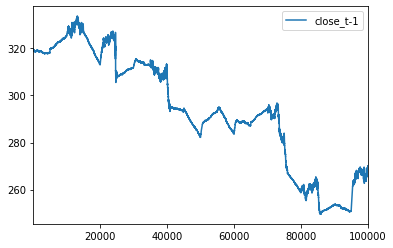

In [64]:
# Now plot close price and volume overtime.
import matplotlib.pyplot as plt
import pandas as pd

df[:100000].plot(y=["close_t-1"])
plt.show()

In [65]:
# Select columns for output
# columns_selected=[
#                  'rsi_10' ,'mom_10','ema_10','ema_20','ema_30',
#                  'sma_10','sma_20','sma_30','wma_10','wma_20','wma_30',
#                  'trima_10','trima_20','trima_30',
#                  'roc_10','rocr_10','ppo_10',
#                  'close','close_t-1','close_t-2','close_t-3','close_t-4',
#                  'label']

# selection through grid search
columns_selected = ['rsi_10','willr_10','macd_macd','cci_10','mom_10','stoch_slowk','stoch_slowd','sma_5','sma_10',
                    'wma_10','ema_10','trima_10','adx_10','bbands_upperband','bbands_lowerband','roc_10',
                    'aroon_aroondown','aroon_aroonup','label']

# Export processed data
output = pd.DataFrame(df, columns=columns_selected)
# output.to_csv(RESULT_FILEPATH_PROCESSED, sep=';', encoding='utf-8', index = False)

# Printing classes distributions
print("Class distribution: ")
label_zero=len(df[df['label'] == 0])
label_one=len(df[df['label'] == 1])
#print(label_zero)
#print(label_one)
print("0 in "+str(float(label_zero)/(label_one+label_zero))+"%")
print("1 in "+str(float(label_one)/(label_one+label_zero))+"%")

%notify -m "Parsing is finished"

Class distribution: 
0 in 0.45386459017377073%
1 in 0.5461354098262293%


<IPython.core.display.Javascript object>

In [66]:
len(df)

1499965

<AxesSubplot:>

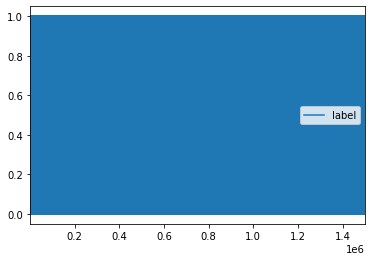

In [67]:
output.plot(y=["label"])
